In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits
from lmfit import Model, Parameters, minimize
import scipy.ndimage
import copy
from scipy.ndimage.filters import gaussian_filter
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D

[-77.39386452   4.5591091   86.51208273 168.46505636 250.41802998
 332.37100361 414.32397724 496.27695086 578.22992449 660.18289812]


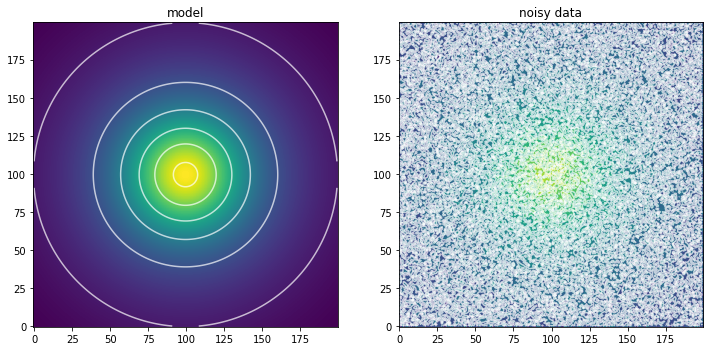

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
n_0     4.989     -inf      inf  0.02015     True     None     None
n_u      1.01     -inf      inf  0.01062     True     None     None
r_0     397.8     -inf      inf    2.902     True     None     None
5 1 400


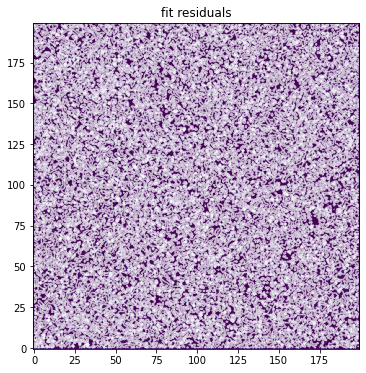

In [168]:
X = 1000
Y = 1000
depth = 100
num = 200
R = 400
bkg = 1
rho_o = 5

x = np.linspace(-X,X,num)
y = np.linspace(-Y,Y,num)
xy_mesh = np.meshgrid(x,y)

def Ngas_model(xy_mesh,n_0, r_0, n_u):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt(x**2+y**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*r_0**2)/sqrt)
    return np.ravel(result)

noise_factor = 0.11
model = Ngas_model(xy_mesh, rho_o, R, bkg).reshape(np.outer(x, y).shape)
data = model + noise_factor*model.max()*np.random.normal(size=model.shape)

contour_levels = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data))/10)
print(contour_levels)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(model, origin='lower')
CS = plt.contour(model, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,2,2)
plt.title('noisy data')
plt.imshow(data, origin='lower')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.show()

lmfit_model = Model(Ngas_model)
lmfit_result = lmfit_model.fit(np.ravel(data), 
                               xy_mesh=xy_mesh, 
                               n_0=10, 
                               r_0 = 1,
                               n_u = 0)
lmfit_result.params.pretty_print()
print(rho_o, bkg, R)

residual = data - Ngas_model(xy_mesh, lmfit_result.params['n_0'].value, lmfit_result.params['r_0'].value, lmfit_result.params['n_u'].value).reshape(np.outer(x, y).shape)
plt.figure(figsize=(6,6))
plt.title('fit residuals')
plt.imshow(residual**2, origin='lower')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)

[  8.95320991  60.96940531 112.98560072 165.00179612 217.01799153
 269.03418694 321.05038234 373.06657775 425.08277315 477.09896856]


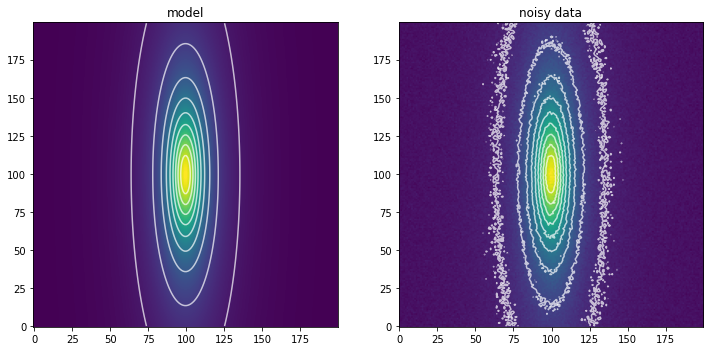

We chose Y
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A           4     0.99      inf 0.003383     True     None     None
n_0         5        0      inf 0.005348     True     None     None
n_u     1.003        0      inf  0.00153     True     None     None
r_0     99.94        0      inf  0.08064     True     None     None
4 5 1 100
26.89473280717132


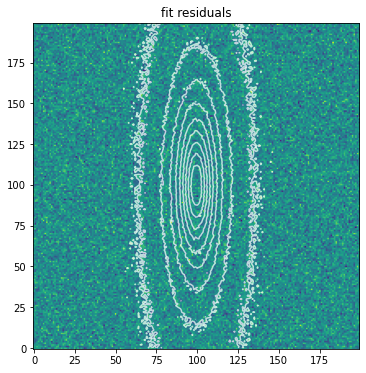

In [169]:
X = 1000
Y = 1000
depth = 25
num = 200
R = 100
bkg = 1
rho_o = 5
A = 4

x = np.linspace(-X,X,num)
y = np.linspace(-Y,Y,num)
xy_mesh = np.meshgrid(x,y)

def Ngas_model(xy_mesh,n_0, r_0, n_u):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt(x**2+y**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*r_0**2)/sqrt)
    return np.ravel(result)

def Ngas_model_x(xy_mesh,n_0, r_0, n_u, A):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt((x/A)**2+y**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*r_0**2)/sqrt)
    return np.ravel(result)

def Ngas_model_y(xy_mesh,n_0, r_0, n_u, A):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt(x**2+(y/A)**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*A*r_0**2)/sqrt)
    return np.ravel(result)

noise_factor = 0.01 

model = Ngas_model_y(xy_mesh, rho_o, R, bkg, A).reshape(np.outer(x, y).shape)
data = model + noise_factor*model.max()*np.random.normal(size=model.shape)

contour_levels = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data))/10)
print(contour_levels)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(model, origin='lower')
CS = plt.contour(model, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,2,2)
plt.title('noisy data')
plt.imshow(data, origin='lower')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.show()

params = Parameters()
params.add('n_0', value=10, min=0)
params.add('r_0', value=1, min=0)
params.add('n_u', value=1.0, min=0)
params.add('A', value=1.0, min = 0.99)

lmfit_model_x = Model(Ngas_model_x)
lmfit_result_x = lmfit_model_x.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_x.params.pretty_print()
#print(lmfit_result_x.fit_report())
#print(lmfit_result_x.redchi)

lmfit_model_y = Model(Ngas_model_y)
lmfit_result_y = lmfit_model_y.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_y.params.pretty_print()
#print(lmfit_result_y.fit_report())
#print(lmfit_result_y.redchi)
if lmfit_result_y.redchi < lmfit_result_x.redchi:
    lmfit_result = lmfit_result_y
    fit = Ngas_model_y(xy_mesh, lmfit_result_y.params['n_0'].value, lmfit_result_y.params['r_0'].value, lmfit_result_y.params['n_u'].value, lmfit_result_y.params['A'].value).reshape(np.outer(x, y).shape)
    print('We chose Y')
else:
    lmfit_result = lmfit_result_x
    fit = Ngas_model_x(xy_mesh, lmfit_result_x.params['n_0'].value, lmfit_result_x.params['r_0'].value, lmfit_result_x.params['n_u'].value, lmfit_result_x.params['A'].value).reshape(np.outer(x, y).shape)
    print('We chose X')

lmfit_result.params.pretty_print()

print(A, rho_o, bkg, R)
print(lmfit_result.redchi)
residual = data - fit

plt.figure(figsize=(6,6))
plt.title('fit residuals')
plt.imshow(residual, origin='lower')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)

Contour Levels:  [ 83.97566604 115.27306758 146.57046911 177.86787064 209.16527217
 240.4626737  271.76007523 303.05747676 334.35487829 365.65227982]


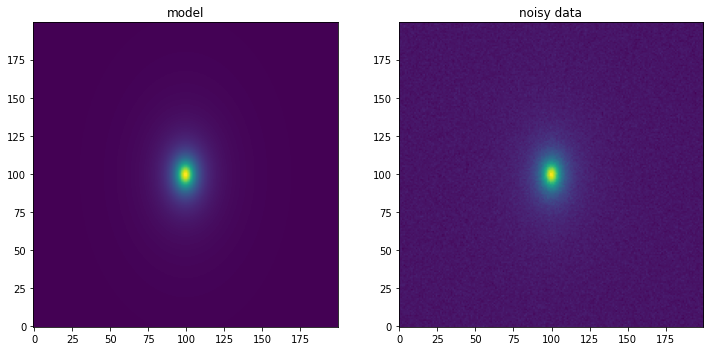

[15.428855167282803, 22.43043757043955, 22.78966687154396, 15.431221334719643]
<function Ngas_model_pro_par at 0x7faed6ee3af0>
<function Ngas_model_pro_par at 0x7faed6ee3af0>
[[Model]]
    Model(Ngas_model_pro_par)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 40000
    # variables        = 5
    chi-square         = 617077.062
    reduced chi-square = 15.4288552
    Akaike info crit   = 109454.578
    Bayesian info crit = 109497.562
    R-squared          = 0.94265513
[[Variables]]
    n_0:  4.57668721 +/- 16000.2102 (349602.44%) (init = 10)
    r_0:  50.3002986 +/- 0.14012960 (0.28%) (init = 1)
    n_u:  0.99977099 +/- 2.2563e-04 (0.02%) (init = 1)
    A:    1.61624381 +/- 5650.42794 (349602.45%) (init = 1)
    i:    0.51195788 +/- 10080.3042 (1968971.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, i)     = 1.000
    C(n_0, i)   = -1.000
    C(n_0, A)   = -1.000
    C(r_0, n_u) = -0.362
Name  

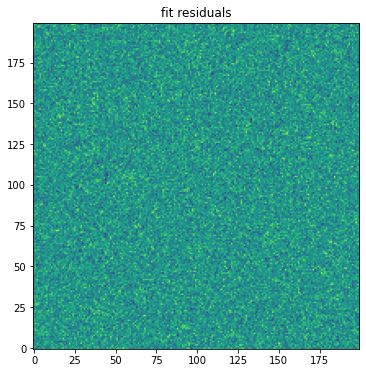

In [211]:
X = 1000
Y = 1000
depth = 100
num = 200
smooth = 10

R = 50
bkg = 1
rho_o = 5
A = 1.5
angle = 0
i = angle*np.pi/180

x = np.linspace(-X,X,num)
y = np.linspace(-Y,Y,num)
xy_mesh = np.meshgrid(x,y)


def Ngas_model_pro_par(xy_mesh,n_0, r_0, n_u, A, i):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt((x**2+r_0**2)*(1+(A**2-1)*(np.cos(i))**2)+y**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*A*r_0**2)/sqrt)
    return np.ravel(result)

def Ngas_model_pro_per(xy_mesh,n_0, r_0, n_u, A, i):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt((x/A)**2+y**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*r_0**2)/sqrt)
    return np.ravel(result)

def Ngas_model_obl_par(xy_mesh,n_0, r_0, n_u, A, i):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt(((x/A)**2+r_0**2)*(1+(A**2-1)*(np.sin(i))**2)+y**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*A*r_0**2)/sqrt)
    return np.ravel(result)

def Ngas_model_obl_per(xy_mesh,n_0, r_0, n_u, A, i):
    (x, y) = xy_mesh
    z = depth/2
    sqrt = np.sqrt(x**2+(y/A)**2+r_0**2)
    result = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*A*r_0**2)/sqrt)
    return np.ravel(result)

noise_factor = 0.01 
choice = Ngas_model_pro_par  # Ngas_model_pro_par, Ngas_model_pro_per, Ngas_model_obl_par, Ngas_model_obl_per
model = choice(xy_mesh, rho_o, R, bkg, A, i).reshape(np.outer(x, y).shape)

data = model + noise_factor*model.max()*np.random.normal(size=model.shape)
contour_levels = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data))/10)
#cont = scipy.ndimage.zoom(data, zoom = 1, order = smooth)
print('Contour Levels: ',contour_levels)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(model, origin='lower')
#CS = plt.contour(model, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,2,2)
plt.title('noisy data')
plt.imshow(data, origin='lower')
#CS = plt.contour(cont, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.show()

params = Parameters()
params.add('n_0', value=10, min=0)
params.add('r_0', value=1, min=0)
params.add('n_u', value=1.0, min=0)
params.add('A', value=1.0, min = 0.99)
params.add('i', value=1, min = 0, max = np.pi/2)

lmfit_model_pro_par = Model(Ngas_model_pro_par)
lmfit_result_pro_par = lmfit_model_pro_par.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_pro_par.params.pretty_print()
#print(lmfit_result_pro_par.fit_report())
#print(lmfit_result_pro_par.redchi)

lmfit_model_pro_per = Model(Ngas_model_pro_per)
lmfit_result_pro_per = lmfit_model_pro_per.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_pro_per.params.pretty_print()
#print(lmfit_result_pro_per.fit_report())
#print(lmfit_result_pro_per.redchi)

lmfit_model_obl_par = Model(Ngas_model_obl_par)
lmfit_result_obl_par = lmfit_model_obl_par.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_obl_par.params.pretty_print()
#print(lmfit_result_obl_par.fit_report())
#print(lmfit_result_obl_par.redchi)

lmfit_model_obl_per = Model(Ngas_model_obl_per)
lmfit_result_obl_per = lmfit_model_obl_per.fit(np.ravel(data), 
                               xy_mesh = xy_mesh, 
                               params = params)
#lmfit_result_obl_per.params.pretty_print()
#print(lmfit_result_obl_per.fit_report())
#print(lmfit_result_obl_per.redchi)

chi = [lmfit_result_pro_par.redchi, lmfit_result_pro_per.redchi, lmfit_result_obl_par.redchi, lmfit_result_obl_per.redchi]
results = [lmfit_result_pro_par, lmfit_result_pro_per, lmfit_result_obl_par, lmfit_result_obl_per]
models = [Ngas_model_pro_par, Ngas_model_pro_per, Ngas_model_obl_par, Ngas_model_obl_per]
best = models[chi.index(min(chi))]
result = results[chi.index(min(chi))]
print(chi)
print(choice)
print(best)
print(result.fit_report(show_correl=True))
result.params.pretty_print()
print(A, i, rho_o, bkg, R)

fit =  best(xy_mesh, result.params['n_0'].value, result.params['r_0'].value, result.params['n_u'].value, result.params['A'].value, result.params['i'].value).reshape(np.outer(x, y).shape)


residual = data - fit

plt.figure(figsize=(6,6))
plt.title('fit residuals')
plt.imshow(residual, origin='lower')
#CS = plt.contour(cont, levels=contour_levels, colors = 'white', alpha = 0.7)

Do one at an angle
Do a double (symetric one)
then do a double witth different values
then a double with one at an angle 
try and fit data with that model t

In [214]:
print(data)
print(data.shape)
print(xy_mesh)

[[104.60776893  95.14693949  94.5514532  ...  93.20026877 103.99817481
  104.31840503]
 [101.48586001 104.95122083  97.33412389 ... 102.18187942 101.77746348
  105.78006574]
 [102.02051698  95.22447866 105.53756869 ... 108.19581212 102.64042147
  105.1798669 ]
 ...
 [101.12227554  99.09827152 102.01652867 ...  99.56099776  94.97604877
  101.115684  ]
 [107.41051693 106.70946875  95.69991651 ...  95.31347735 106.44943156
   88.44042825]
 [102.02592243  96.75094863 101.88851299 ... 100.60042821 102.56183083
  103.00255719]]
(200, 200)
[array([[-1000.        ,  -989.94974874,  -979.89949749, ...,
          979.89949749,   989.94974874,  1000.        ],
       [-1000.        ,  -989.94974874,  -979.89949749, ...,
          979.89949749,   989.94974874,  1000.        ],
       [-1000.        ,  -989.94974874,  -979.89949749, ...,
          979.89949749,   989.94974874,  1000.        ],
       ...,
       [-1000.        ,  -989.94974874,  -979.89949749, ...,
          979.89949749,   989.949

26.373916712892765


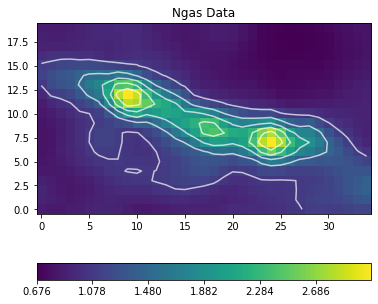

0.6756818656364513 3.0874778901754043
[0.67568187 1.07764787 1.47961387 1.88157988 2.28354588 2.68551189]
3.1078571428571427
(20, 35)
(20, 35)


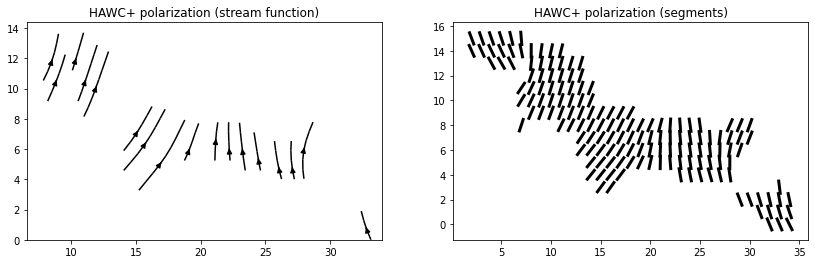

In [4]:
import itertools
depth = 0.01685*5/0.003194444
print(depth)
xcenter=18.63 #18.56
ycenter=-0.065#-0.1
coords = SkyCoord(l=xcenter*u.degree, b=ycenter*u.degree, frame='galactic', unit= (u.deg) )
width= 35
height= 20
X = width
Y = height
'''
Ngas Beam
0.01216666666666667
SOFIA beam
0.005055555556
'''
'''
First regrid Stokes U and Q then calculate the polarisation angle and intensity from that !!! 
'''



column_density_file = '/home/jessym/harvard/fil_5/fits/HIGAL_L_Fil5_Ngas.fits'
column_fits = fits.open(column_density_file)
column_data = column_fits[0].data
column_header = column_fits[0].header
column_world = WCS(column_header)
column_centre = column_world.world_to_pixel(coords)



BAngle_file = '/home/jessym/harvard/fil_5/fits/Fil5_BAngle_reprojectGal.fits'
BAngle_fits = fits.open(BAngle_file)
BAngle_data = BAngle_fits[0].data
BAngle_header = BAngle_fits[0].header
p = fits.open('/home/jessym/harvard/fil_5/fits/Fil5_Percent_debiased_reprojectGal.fits')[0].data
p_e = fits.open('/home/jessym/harvard/fil_5/fits/Fil5_Percent_e_reprojectGal.fits')[0].data
sn = p/p_e
(ys,xs)=p.shape

for y in range(0,ys,1):
    for x in range(0,xs,1):
        if sn[y,x] >= 3 and p[y,x] != 'nan':
            continue
        else:
            BAngle_data[y,x] = np.nan

#BAngle_world = WCS(BAngle_header)
#BAngle_centre = BAngle_world.world_to_pixel(coords)

from reproject import reproject_exact
widths = fits.open('/home/jessym/harvard/fil_5/fits/line_analysis/grs_fit/13CO_cube_single_width.fits')[0]
widths_reproj = reproject_exact(widths, column_header, return_footprint = False)
widths_cut = Cutout2D(widths_reproj, column_centre, (height, width)).data
B_reproj = reproject_exact((BAngle_data, BAngle_header), column_header, return_footprint = False)
BAngle_data_cut = Cutout2D(B_reproj, column_centre, (height, width)).data
#BAngle_data_cut = np.array(itertools.islice(BAngle_data_cut, 0, None, 3))
data = Cutout2D(column_data, column_centre, (height, width)).data
med = np.median(data)

emptymap = np.copy(data)
emptymap[:] = np.nan
mask = emptymap.copy()

for i in range(np.shape(data)[0]):
    for j in range(np.shape(data)[1]):
        if 2e22 <= data[i,j]: # and not np.isnan(widths_cut[i,j])
            mask[i,j] = 1
        else:
            mask[i,j] = np.nan

BAngle_data_cut = BAngle_data_cut*mask

Bdir_x = -np.sin(np.array(BAngle_data_cut)*np.pi/180)
Bdir_y = np.cos(np.array(BAngle_data_cut)*np.pi/180)
save = []


norm_data = data/med
plt.figure(figsize=(6,6))
plt.title('Ngas Data')
plt.imshow(norm_data, origin='lower')
contour_levels = np.arange(np.nanmin(norm_data), np.nanmax(norm_data), (np.nanmax(norm_data)-np.nanmin(norm_data))/6)
plt.colorbar(location='bottom', ticks = contour_levels)
#cont = gaussian_filter(data, 1)
CS = plt.contour(norm_data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.savefig('send_phil/Ngas_data.pdf')
plt.show()
print(np.min(norm_data), np.max(norm_data))
print(contour_levels)
print(43.51/14)
print(np.shape(BAngle_data_cut))
print(np.shape(Bdir_x))

x = np.arange(0,np.shape(BAngle_data_cut)[1],1)
y = np.arange(0,np.shape(BAngle_data_cut)[0],1)
xarr, yarr = np.meshgrid(x,y)
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3.4))
#plt.imshow(BAngle_data_cut, origin='lower')
#plt.colorbar(location = 'bottom')
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='k')
plt.title('HAWC+ polarization (stream function)')
#plt.show()

plt.subplot(1,2,2)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=data_angle.shape
step=1
scale=step
#plt.figure(figsize=(6,3.4))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])

        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'k',  linewidth=3) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.title('HAWC+ polarization (segments)')
plt.savefig('send_phil/HAWC+_polarization.pdf')
plt.show()

(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(20, 35)
(

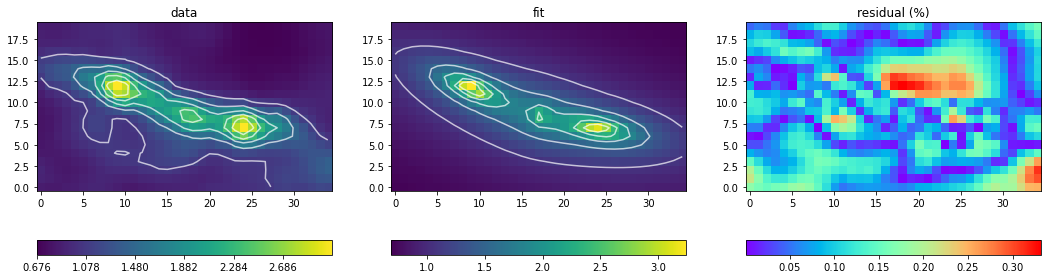

In [5]:
def fitting(mesh,n_0_1, n_0_2, n_0_3, r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            z = depth/2
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)


grid = np.zeros([Y, X])

params = Parameters()
params.add('n_0_1', value=np.max(norm_data), min=0)
params.add(name="factor", value = 0.8, min=0, max=0.9)
params.add('n_0_2', value=0.01, min=0, expr='n_0_1 * factor')
params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1.278, min=0.5)
params.add('r_0_2', value=1.116, min=0.3)
params.add('r_0_3', value=1.141, min=0.5)
params.add('n_u', value=np.min(norm_data), min=0)
params.add('A_1', value=1.5, min = 1)
params.add('A_2', value=1., min = 1, max=3, vary = False)
params.add('A_3', value=1.7, min = 1)
params.add('theta_1', value=0, min = -np.pi/2, max = np.pi/2)
params.add('theta_2', value= -0.3369, min = -np.pi/2, max = np.pi/2, vary = False)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2)
params.add('xcentre_1', value=9.048, min = 0, vary = False)
params.add('ycentre_1', value=11.69, min = 0, vary = False)
params.add('xcentre_2', value=17.33, min = 0, max = 36, vary = True)
params.add('ycentre_2', value=8.234, min = 0, max = 15, vary = True)
params.add('xcentre_3', value=24.03, min = 0, vary = False)
params.add('ycentre_3', value=6.902, min = 0, vary = False)

lmfit_model_pro_per = Model(fitting)
result = lmfit_model_pro_per.fit(norm_data, 
                               mesh = grid, 
                               params = params) #method = ''

print('reduced chi2 = ', result.redchi)
#print(result.fit_report(show_correl=True))
result.params.pretty_print()

fit =  fitting(grid, result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value,\
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value)

 
#fit =  fitting(grid, rho_o_1, rho_o_2, rho_o_3, R1, R2, R3, bkg, A1, A2, A3, theta_1, theta_2, theta_3, x0_1, y0_1, x0_2, y0_2, x0_3, y0_3)
residual = abs((fit - norm_data)/norm_data)
contour_levels = np.arange(np.nanmin(norm_data), np.nanmax(norm_data), (np.nanmax(norm_data)-np.nanmin(norm_data))/6)
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
plt.grid(visible=False)
plt.colorbar(ticks = contour_levels, orientation='horizontal') # location = 'bottom')
CS = plt.contour(norm_data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
CS = plt.contour(fit, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual, origin='lower', cmap='rainbow')
#CS = plt.contour(norm_data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.show()



nu =  218.9986403468506
n0 =  45110.664014363116
205.98604604538517



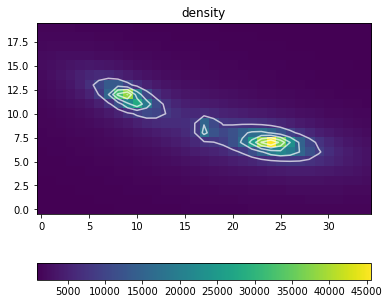

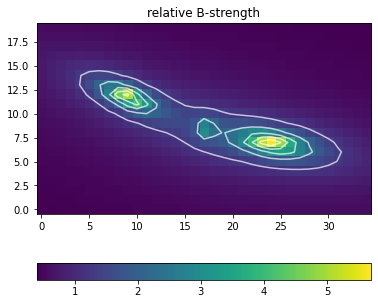

In [22]:
n01, n02,  r01, r02, r03, nu, A1, A2, A3, theta1, theta2, theta3, x1, y1, x2, y2, x3, y3 = result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value,\
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value
n03=n01
X = 35
Y = 20
grid = np.zeros([Y, X])

N = (np.pi*n01*r01)


pc_in_deg = 0.01685
pix_in_deg = 0.003194444 
pc_in_cm = 3.086e+18
pix_per_cm = pc_in_cm*pix_in_deg/pc_in_deg
print('nu = ', nu*med/pix_per_cm)
print('n0 = ', n01*med/pix_per_cm)
nu = nu*med/pix_per_cm
n01 = n01*med/pix_per_cm
n02 = n02*med/pix_per_cm
n03 = n03*med/pix_per_cm
v01 = n01/nu
v02 = n02/nu
v03 = n03/nu
print(v01)
print
print()
def rho(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            part_1 = nu+(n01/frac_1)
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            part_2 = nu+(n02/frac_2)
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            part_3 = nu+(n03/frac_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)
density = rho (grid)
contour_levels = np.arange(np.nanmin(density), np.nanmax(density), (np.nanmax(density)-np.nanmin(density))/6)
plt.figure(figsize=(6,6))
plt.title('density')
plt.imshow(density, origin='lower')
plt.colorbar(location='bottom')
CS = plt.contour(density, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.show()

#rel_B = (density/nu)**(2/3)
rel_B = (density/np.mean(density))**(2/3)
contour_levels = np.arange(np.nanmin(rel_B), np.nanmax(rel_B), (np.nanmax(rel_B)-np.nanmin(rel_B))/6)


plt.figure(figsize=(6,6))
plt.title('relative B-strength')
plt.imshow(rel_B, origin='lower')
plt.colorbar(location='bottom')
CS = plt.contour(rel_B, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.show()

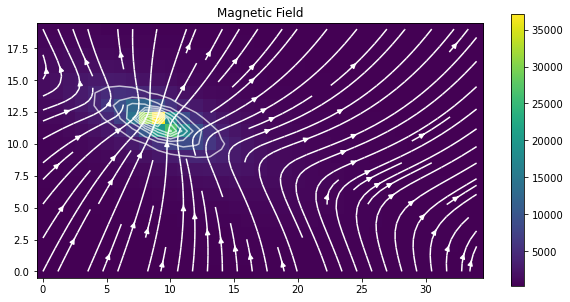

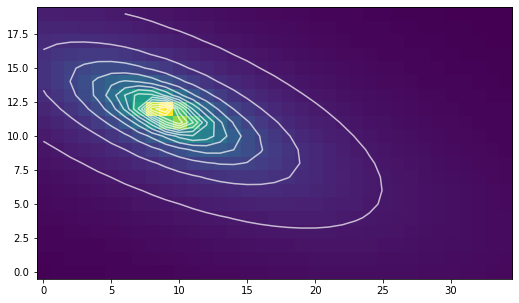

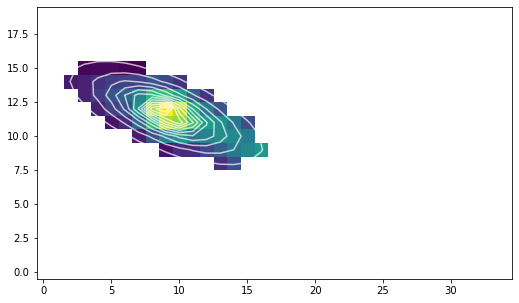

Mean Number density:  4846.142142928553
Median Number density:  4454.549077152459
B_bar : 9.255930173212849e-05
Bu =  4.221830633537802e-06
B0 =  0.00014772755811076353
205.98604604538517
Angle dispersion =  23.044155277781385


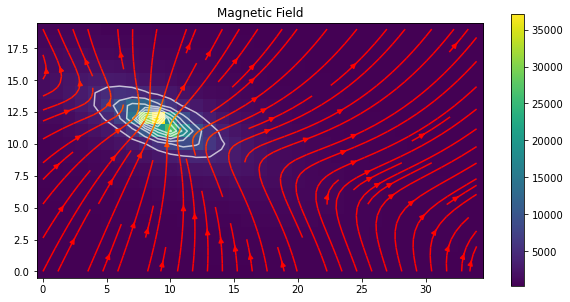

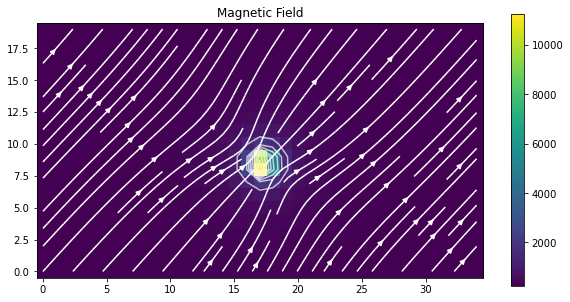

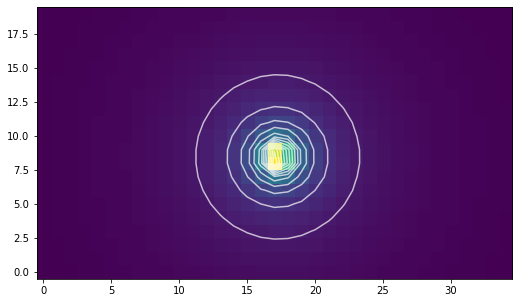

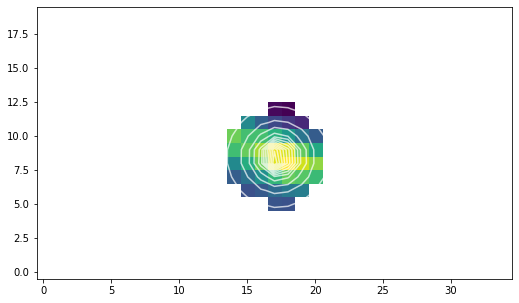

Mean Number density:  4686.994524703075
Median Number density:  4796.928113609755
B_bar : 0.0003876600698031173
Bu =  7.933540535959593e-05
B0 =  0.002588678464154037
185.38742070758667
Angle dispersion =  5.700809539581071


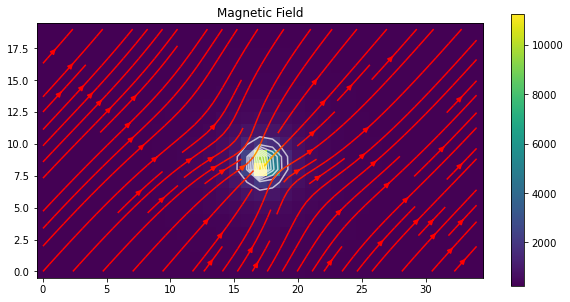

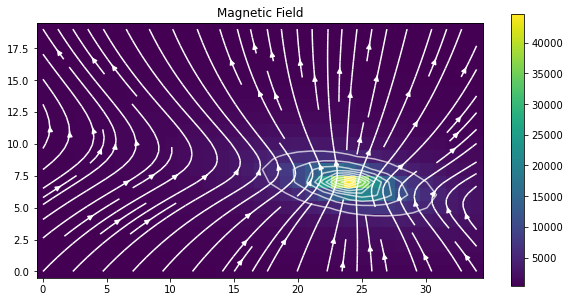

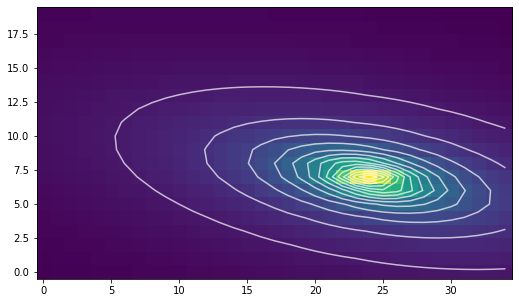

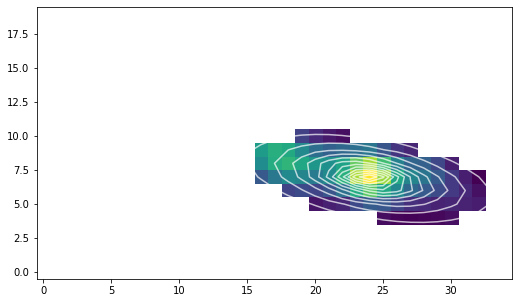

Mean Number density:  4738.299142950854
Median Number density:  4506.1074242202585
B_bar : 0.00013220042223232095
Bu =  4.766208177654079e-06
B0 =  0.0001667760639043847
205.98604604538517
Angle dispersion =  17.87526334958298


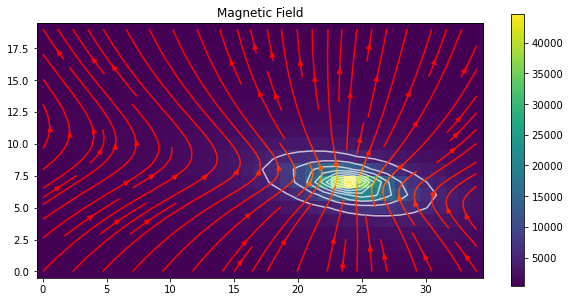

/tmp/ipykernel_446/2361592873.py:292: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)


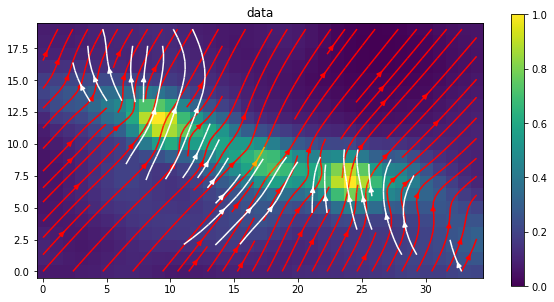

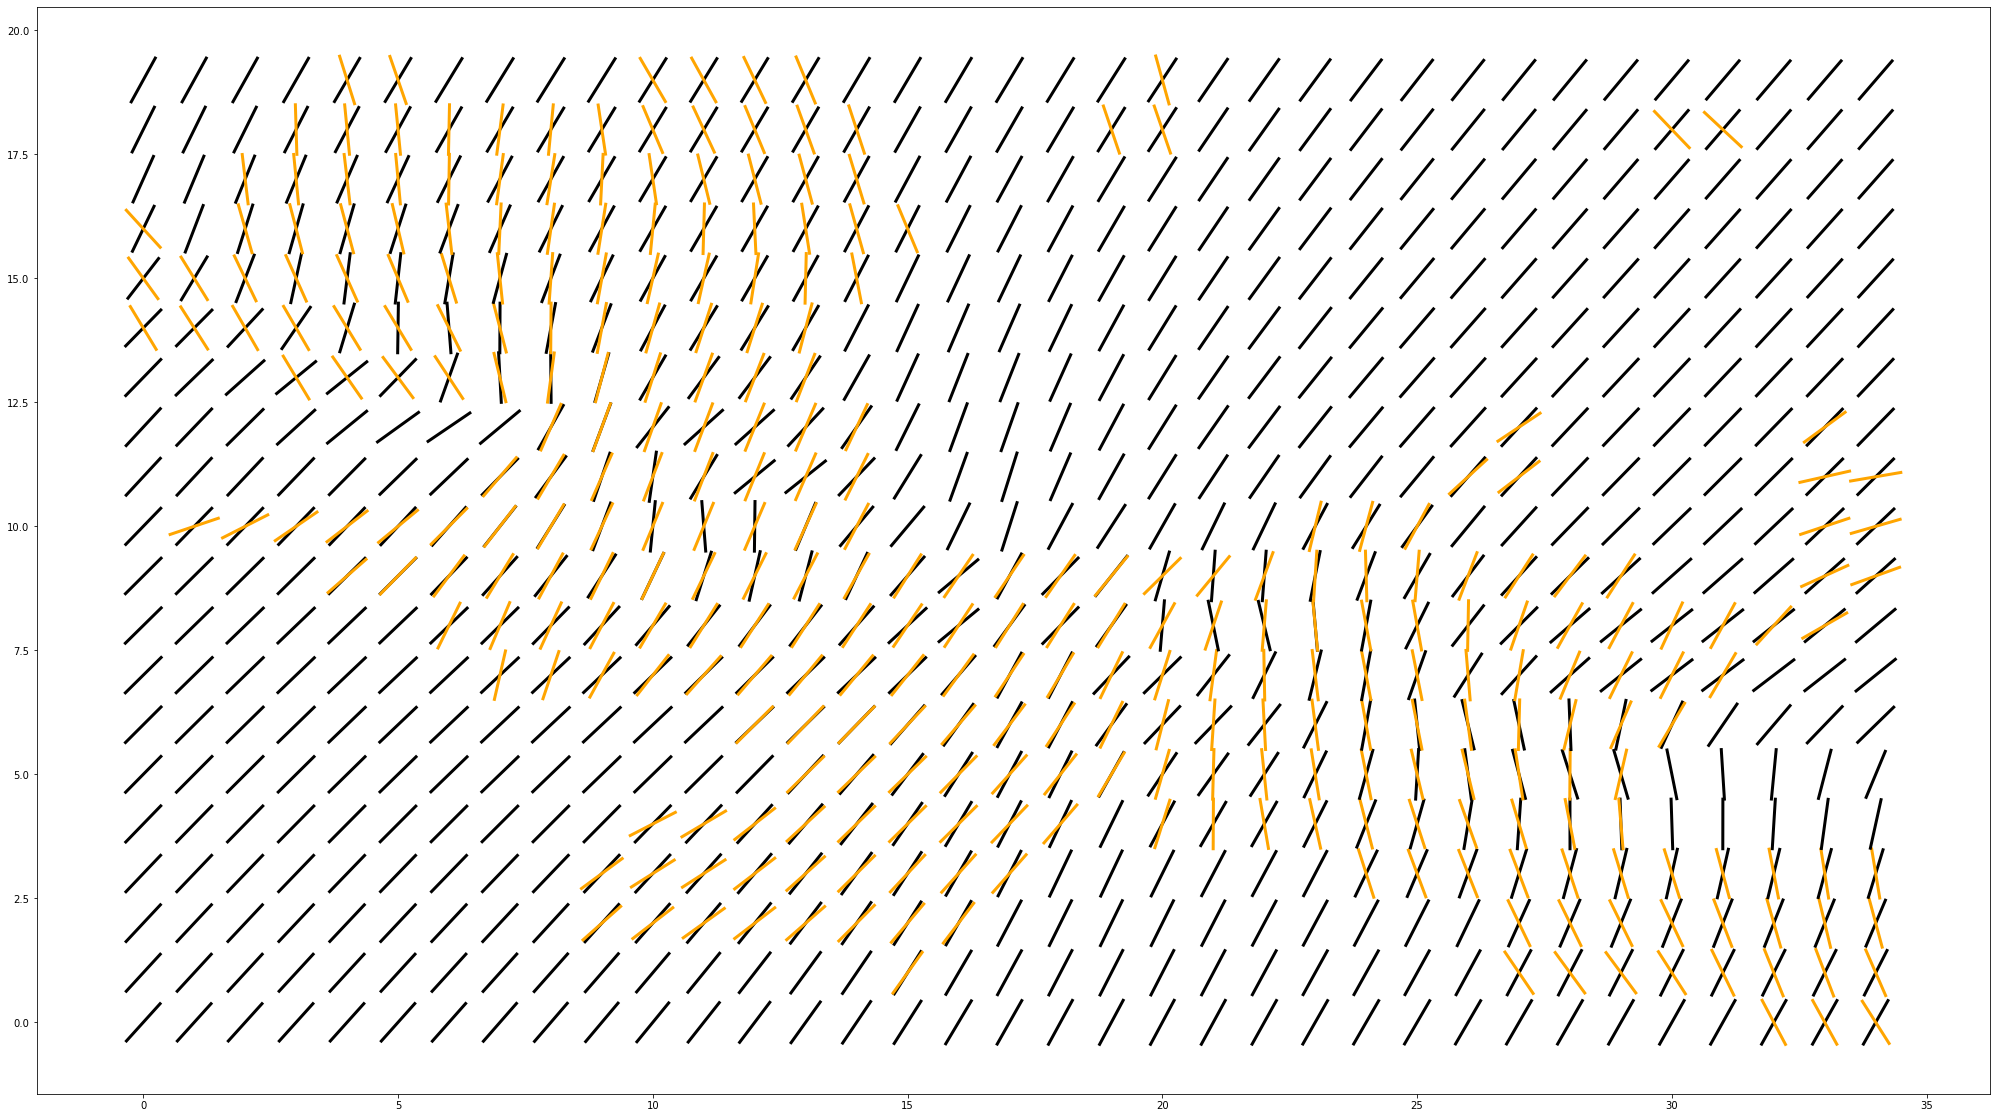

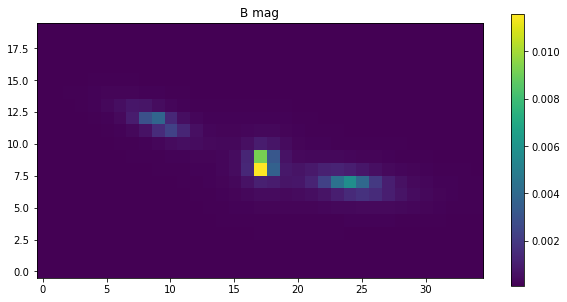

In [24]:
# 1D arrays
theta2=-0.7

width= 35
height=20
X = width
Y = height
z = depth/2

mean_molecular_weight = 2.37 
mu_times_mp = mean_molecular_weight*1.68571016E-24
pixel_size_arcsec = 0.003194444*3600
box_height = 15*6.6/3.4
filament_radius_pc = 1.1
distance = 3400 #pc
cm_in_pc = 3085677581279958500 
cm_in_au = 1.49598073e+13
filament_radius_cm = filament_radius_pc*cm_in_pc
R = filament_radius_cm



grid = np.zeros([Y, X])

x = np.arange(0,X,1)
y = np.arange(0,Y,1)
X,Y = np.meshgrid(x,y)


def lowest_stddev(input_array):
	#delete nan's and unravel
	input_array = np.ravel(input_array)
	nonans = input_array[~np.isnan(input_array)]
	#add 180
	nonans_p180 = [i+180 if i < 0 else i for i in nonans]  
	#nonans_m180 = [i-180 if i > 0 else i for i in nonans]  this is same as above
	#check_distribution(nonans,nonans_p180)
	min_std = np.min([np.std(nonans),np.std(nonans_p180)])
	if np.std(nonans) < np.std(nonans_p180):
		best_median = np.median(nonans)
	else:
		best_median = np.median(nonans_p180)
	return min_std,best_median

def single_1(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            mesh[y,x] = nu+(n01/frac_1)
    return np.array(mesh)
def single_2(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            mesh[y,x] = nu+(n02/frac_2)
    return np.array(mesh)
def single_3(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            mesh[y,x] = nu+(n03/frac_3)
    return np.array(mesh)

def sigle_1_Ngas(mesh,n_0_1, r_0_1, n_u, A_1, theta_1, xcentre_1, ycentre_1):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            mesh[y,x] = part_1
    return np.array(mesh)

def sigle_2_Ngas(mesh, n_0_2, r_0_2, n_u, A_2, theta_2, xcentre_2, ycentre_2):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            mesh[y,x] = part_2
    return np.array(mesh)

def sigle_3_Ngas(mesh,n_0_3, r_0_3, n_u, A_3, theta_3, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_3
    return np.array(mesh)


first = single_1(grid)
second = single_2(grid)
third = single_3(grid)

first_Ngas = sigle_1_Ngas(grid, n01, r01, nu, A1, theta1, x1, y1)
second_Ngas = sigle_2_Ngas(grid, n02, r02, nu, A2, theta2, x2, y2)
third_Ngas = sigle_3_Ngas(grid, n03, r03, nu, A3, theta3, x3, y3)

# Assign vector directions

n1mean = np.mean(first)
n2mean = np.mean(second)
n3mean = np.mean(third)

t = grid.copy()
s = grid.copy()
ang = grid.copy()
check = grid.copy()
thetaB_1 = grid.copy()
v_bar_1 = grid.copy()
v_1 = grid.copy()
B_x_1 = grid.copy()
B_y_1 = grid.copy()
B_1 = grid.copy()
thetaB_2 = grid.copy()
v_bar_2 = grid.copy()
v_2 = grid.copy()
B_x_2 = grid.copy()
B_y_2 = grid.copy()
thetaB_3 = grid.copy()
v_bar_3 = grid.copy()
v_3 = grid.copy()
B_x_3 = grid.copy()
B_y_3 = grid.copy()
for y in range(len(first)):
    for x in range(len(first[y])):
        x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
        y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
        w1 = np.sqrt((x_1/(A1*r01))**2+(y_1/r01)**2)
        t_1 = (1+v01/(1+w1**2))/(1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        s_1 = x_1/y_1
        thetaB_1[y,x] = np.arctan((1-t_1)/((1/s_1)+(s_1*t_1/(A1**2))))
        v_1[y,x] = (1+v01/(1+w1**2))
        v_bar_1[y,x] = (1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        
        B_x_1[y,x] = np.sin(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)
        B_y_1[y,x] = np.cos(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)

        
        x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
        y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
        w2 = np.sqrt((x_2/(A2*r02))**2+(y_2/r02)**2)
        t_2 = (1+v02/(1+w2**2))/(1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        s_2 = x_2/y_2
        thetaB_2[y,x] = np.arctan((1-t_2)/((1/s_2)+(s_2*t_2/(A2**2))))
        v_2[y,x] = (1+v02/(1+w2**2))
        v_bar_2[y,x] = (1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        B_x_2[y,x] = np.sin(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)  #We set the correction for the elongated core as the fraction between the densities to the 2/3
        B_y_2[y,x] = np.cos(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)
        
        x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
        y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3) 
        w3 = np.sqrt((x_3/(A3*r03))**2+(y_3/r03)**2)
        t_3 = (1+v03/(1+w3**2))/(1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        s_3 = x_3/y_3
        thetaB_3[y,x] = np.arctan((1-t_3)/((1/s_3)+(s_3*t_3/(A3**2))))
        v_3[y,x] = (1+v03/(1+w3**2))
        v_bar_3[y,x] = (1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        B_x_3[y,x] = np.sin(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        B_y_3[y,x] = np.cos(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        '''
        ang[y,x] = theta
        check[y,x] = (1-t_1)/((1/s_1)+(s_1*t_1/(A1**2)))
        t[y,x] = t_1
        s[y,x] = s_1
        
        if np.sqrt((x1-x)**2+(y1-y)**2) < 15*r01:
            E_x[y,x] = np.sin(-theta1)+(t_1**(2/3))*np.sin(theta-theta1)
            E_y[y,x] = np.cos(-theta1)+(t_1**(2/3))*np.cos(theta-theta1)
        else:
            E_x[y,x] = np.sin(-theta1)
            E_y[y,x] = np.cos(-theta1)
'''
        
        ## data = norm_data
def B_estimate_core(Density_model, Ngas_model, cont_level, Continue, B_x, B_y, v_arr, v_bar_arr, v0, Velocity_dispersion_data,\
                    B_angle_data, Ngas_data,Box_height):
    '''
    Start with cont_level = 0 then choose the appropriate contour and wheter to do density or 
    Run the function with Continue = False first and box_height = 5 then figure out what the box height 
    actually is based on what you see in the cutout plot.
    Once happy with everything just set Continue = True
    '''
    x = np.arange(0,np.shape(Density_model)[1],1)
    y = np.arange(0,np.shape(Density_model)[0],1)
    X,Y = np.meshgrid(x,y)
    
    Density_model_contour_levels = np.arange(np.nanmin(Density_model), np.nanmax(Density_model), (np.nanmax(Density_model)-np.nanmin(Density_model))/10)
    plt.figure(figsize=(10, 5))
    plt.imshow(Density_model, origin='lower')
    plt.colorbar()
    CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color='white', cmap="autumn")
    plt.title('Magnetic Field')
    plt.show()
    #
    
    
    Ngas_model_contour_levels = np.arange(np.nanmin(Ngas_model), np.nanmax(Ngas_model), (np.nanmax(Ngas_model)-np.nanmin(Ngas_model))/15)
    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_model, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()

    v
    Velocity_dispersion_data_crop = mask*Velocity_dispersion_data
    v_bar_crop = v_bar_arr*mask
    Ngas_data_crop = Ngas_data*mask

    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_data_crop, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()
    if Continue:
        box_height_cm = Box_height*pixel_size_arcsec*distance*cm_in_au
        z = box_height_cm/2


        ave_column = np.nanmean(Ngas_data_crop)
        median_column = np.nanmedian(Ngas_data_crop)
        number_density = ave_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2)))
        sig_PA,median_PA = lowest_stddev(B_angle_data_crop)

        print('Mean Number density: ', number_density)
        print('Median Number density: ', median_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2))))

        B_bar = 0.5*np.sqrt(4*np.pi*number_density*mu_times_mp)*np.nanmean(Velocity_dispersion_data_crop)*100000/np.radians(sig_PA)
        Bu = B_bar/np.nanmin(v_bar_crop)
        print('B_bar :', B_bar)
        print('Bu = ', Bu)
        print('B0 = ', Bu*(1+v0)**(2/3))
        print(v0)
        print('Angle dispersion = ', sig_PA)
        B = Bu*v_arr*(v_bar_arr)**(-1/3)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(Density_model, origin='lower')
        plt.colorbar()
        CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
        plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color=B, cmap="autumn")
        plt.title('Magnetic Field')
        plt.show()
        return (B_x*B, B_y*B)
    
    else:
        return

(B_x_1, B_y_1) = B_estimate_core(Density_model=first, Ngas_model=first_Ngas, cont_level=3, Continue=True, B_x=B_x_1, B_y=B_y_1,\
                                 v_arr=v_1, v_bar_arr=v_bar_1, v0=v01, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=5)

(B_x_2, B_y_2) = B_estimate_core(Density_model=second, Ngas_model=second_Ngas, cont_level=2, Continue=True, B_x=B_x_2, B_y=B_y_2,\
                                 v_arr=v_2, v_bar_arr=v_bar_2, v0=v02, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=6)

(B_x_3, B_y_3) = B_estimate_core(Density_model=third, Ngas_model=third_Ngas, cont_level=3, Continue=True, B_x=B_x_3, B_y=B_y_3,\
                                 v_arr=v_3, v_bar_arr=v_bar_3, v0=v03, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=5)

### Compare N2H+ and 13CO by themsevles


B_x = B_x_1+B_x_2+B_x_3
B_y = B_y_1+B_y_2+B_y_3
amp = np.sqrt(B_y**2+B_x**2)
plt.figure(figsize=(10, 5))
plt.imshow(data, origin='lower')
plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color=amp, cmap = 'autumn')
plt.title('Magnetic Field')
plt.title('data')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.streamplot(X,Y,Bdir_x,Bdir_y, density=1, linewidth=None, color='white')
plt.colorbar()
plt.show()

model_angle = np.arctan(-B_x/B_y)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=model_angle.shape
dlist=[]
list_m=[] # model vector display info
list_r=[] # data vector display info

step=1
scale=step
plt.figure(figsize=(35, 20))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])
        
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        
        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=3)
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'orange',  linewidth=3) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(amp, origin='lower')
plt.colorbar()
plt.title('B mag')
plt.show()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3.4))
#plt.imshow(BAngle_data_cut, origin='lower')
#plt.colorbar(location = 'bottom')
plt.streamplot(xarr,yarr,Bdir_x,Bdir_y, density=1, linewidth=None, color='k')
plt.title('HAWC+ polarization (stream function)')
#plt.show()



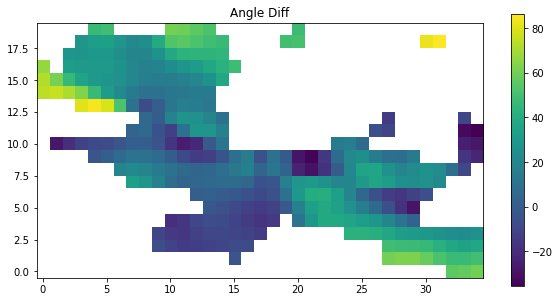

mu =  17.167043276998566 , sigma =  24.670342136880656
median =  17.165990039879894


Text(0, 0.5, 'Normalised density')

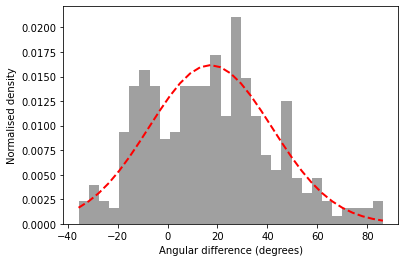

In [25]:
from scipy.stats import norm
import matplotlib.mlab as mlab

ang_dif =  BAngle_data_cut - np.degrees(np.arctan(-B_x/B_y))
plt.figure(figsize=(10, 5))
plt.imshow(ang_dif, origin='lower')
plt.colorbar()
plt.title('Angle Diff')
plt.show()

ang_dif_1d = np.ravel(ang_dif)
ang_dif_clean = list()
for element in ang_dif_1d:
    if not np.isnan(element):
        ang_dif_clean.append(element)

# best fit of data
(mu, sigma) = norm.fit(ang_dif_clean)

# the histogram of the data
n, bins, patches = plt.hist(ang_dif_clean, 30,density=True,  facecolor='grey', alpha=0.75)
print('mu = ', mu, ', sigma = ', sigma)
print('median = ', np.median(ang_dif_clean))
# add a 'best fit' line
y = norm.pdf( bins, mu, sigma) 
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Angular difference (degrees)')
plt.ylabel('Normalised density')

reduced chi2 =  0.0183252841479945
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1           2.553      1.1      inf   0.1532     True     None     None
A_2           4.266        1      inf   0.6498     True     None     None
A_3           2.852        1      inf   0.1738     True     None     None
factor       0.7081        0      0.9   0.2747     True     None     None
n_0_1         1.211        0      inf   0.1005     True     None     None
n_0_2        0.8571        0      inf   0.3153    False n_0_1 * factor     None
n_u        0.007485        0      inf 0.0001451     True     None     None
r_0_1        0.6449        0      inf  0.03744     True     None     None
r_0_2        0.4004        0      inf   0.1034     True     None     None
r_0_3        0.6339        0      inf  0.03807     True     None     None
theta_1     -0.3791  -0.3927    1.571  0.02259     True     None     None
theta_2     -0.3369   -1.571    1.571  0.04056     True     None    

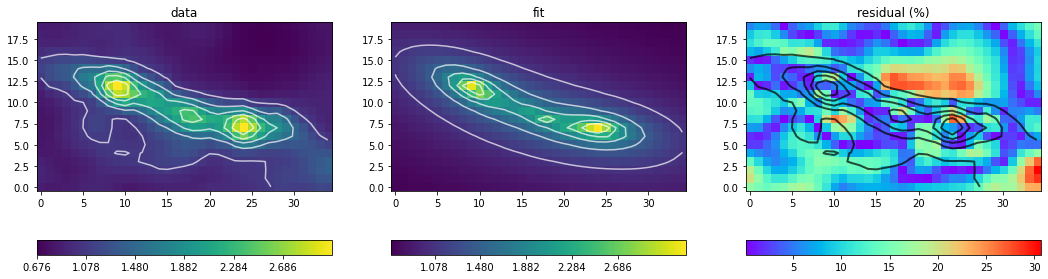

In [40]:
width= 35
height= 20

def fitting(mesh,n_0_1, n_0_2, r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    n_0_3 = n_0_1
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            z = depth/2
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)

X = width
Y = height
grid = np.zeros([Y, X])

params = Parameters()
params.add('n_0_1', value=np.max(norm_data), min=0)
params.add(name="factor", value = 0.5, min=0, max=0.9)
params.add('n_0_2', value=np.max(norm_data), min=0, expr='n_0_1 * factor')
#params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1.278, min=0.)
params.add('r_0_2', value=1.116, min=0.)
params.add('r_0_3', value=1.141, min=0.)
params.add('n_u', value=np.min(norm_data), min=0)
params.add('A_1', value=2, min = 1.1)
params.add('A_2', value=8, min = 1, vary = True)
params.add('A_3', value=1.7, min = 1)
params.add('theta_1', value=0, min = -np.pi/8, max = np.pi/2)
params.add('theta_2', value=0, min = -np.pi/2, max = np.pi/2)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2)
params.add('xcentre_1', value=9.048, min = 0, vary = True)
params.add('ycentre_1', value=11.69, min = 0, vary = True)
params.add('xcentre_2', value=17.33, min = 0, max = 36, vary = False)
params.add('ycentre_2', value=8.234, min = 0, max = 15, vary = False)
params.add('xcentre_3', value=24.03, min = 0, vary = False)
params.add('ycentre_3', value=6.902, min = 0, vary = False)


lmfit_model_pro_per = Model(fitting)
result = lmfit_model_pro_per.fit(norm_data, 
                               mesh = grid, 
                               params = params) #method = ''

print('reduced chi2 = ', result.redchi)
#print(result.fit_report(show_correl=True))
result.params.pretty_print()

fit =  fitting(grid, result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value,\
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value)

 
#fit =  fitting(grid, rho_o_1, rho_o_2, rho_o_3, R1, R2, R3, bkg, A1, A2, A3, theta_1, theta_2, theta_3, x0_1, y0_1, x0_2, y0_2, x0_3, y0_3)
residual = abs((fit - norm_data)/norm_data)
contour_levels = np.arange(np.nanmin(norm_data), np.nanmax(norm_data), (np.nanmax(norm_data)-np.nanmin(norm_data))/6)
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
plt.colorbar(ticks = contour_levels, orientation='horizontal') # location = 'bottom')
CS = plt.contour(norm_data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.colorbar(ticks = contour_levels, location = 'bottom')
CS = plt.contour(fit, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual*100, origin='lower', cmap='rainbow')
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
CS = plt.contour(norm_data, levels=contour_levels, colors = 'black', alpha = 0.7, linewidths = 2)
plt.savefig('send_phil/best_fit_model.pdf')
plt.show()

nu =  224.02447952996226
n0 =  36230.93615961186
161.72757653819764



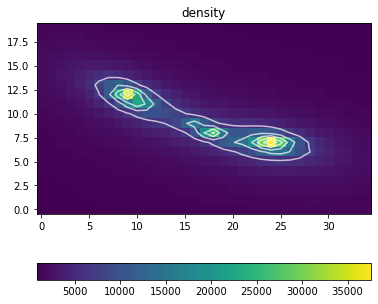

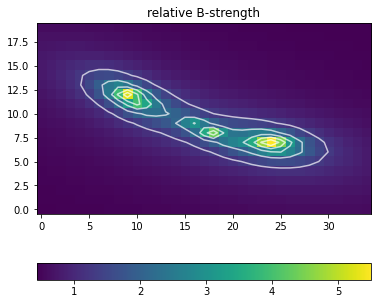

In [41]:
n01, n02,  r01, r02, r03, nu, A1, A2, A3, theta1, theta2, theta3, x1, y1, x2, y2, x3, y3 = result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value,\
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value
n03=n01
X = 35
Y = 20
grid = np.zeros([Y, X])

N = (np.pi*n01*r01)


pc_in_deg = 0.01685
pix_in_deg = 0.003194444 
pc_in_cm = 3.086e+18
pix_per_cm = pc_in_cm*pix_in_deg/pc_in_deg
print('nu = ', nu*med/pix_per_cm)
print('n0 = ', n01*med/pix_per_cm)
nu = nu*med/pix_per_cm
n01 = n01*med/pix_per_cm
n02 = n02*med/pix_per_cm
n03 = n03*med/pix_per_cm
v01 = n01/nu
v02 = n02/nu
v03 = n03/nu
print(v01)
print
print()
def rho(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            part_1 = nu+(n01/frac_1)
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            part_2 = nu+(n02/frac_2)
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            part_3 = nu+(n03/frac_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)
density = rho (grid)
contour_levels = np.arange(np.nanmin(density), np.nanmax(density), (np.nanmax(density)-np.nanmin(density))/6)
plt.figure(figsize=(6,6))
plt.title('density')
plt.imshow(density, origin='lower')
plt.colorbar(location='bottom')
CS = plt.contour(density, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.show()

#rel_B = (density/nu)**(2/3)
rel_B = (density/np.mean(density))**(2/3)
contour_levels = np.arange(np.nanmin(rel_B), np.nanmax(rel_B), (np.nanmax(rel_B)-np.nanmin(rel_B))/6)


plt.figure(figsize=(6,6))
plt.title('relative B-strength')
plt.imshow(rel_B, origin='lower')
plt.colorbar(location='bottom')
CS = plt.contour(rel_B, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.show()

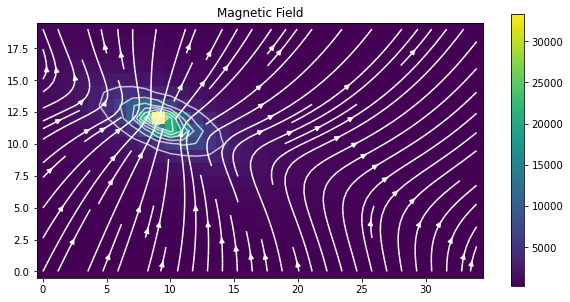

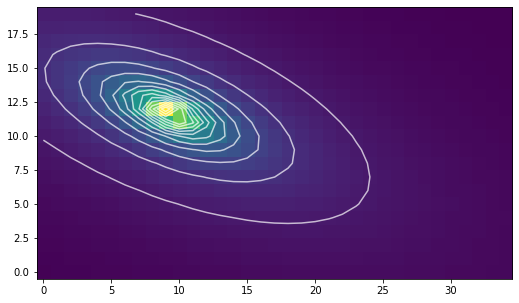

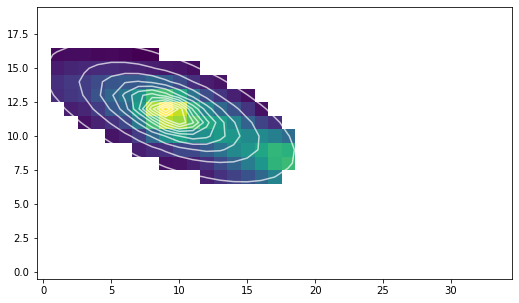

Mean Number density:  4391.900136815038
Median Number density:  3999.4607300162847
B_bar : 9.340637738335167e-05
Bu =  8.080008374210978e-06
B0 =  0.00024083480394138598
161.72757653819764
Angle dispersion =  21.475328713239627


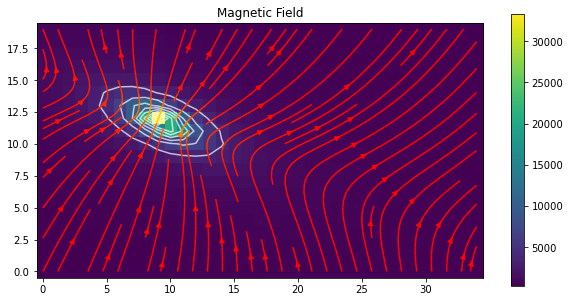

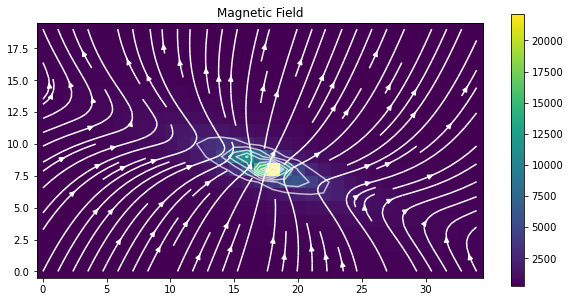

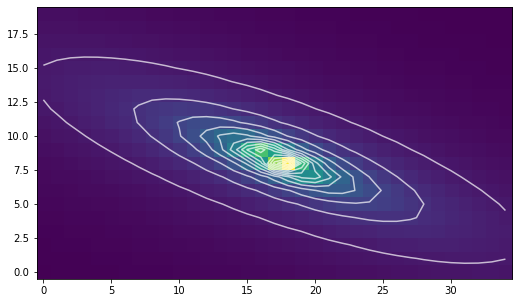

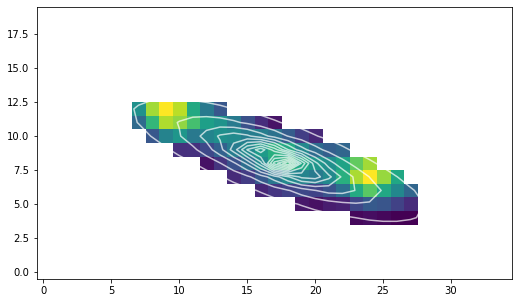

Mean Number density:  4985.450784823877
Median Number density:  5012.8290985490285
B_bar : 0.0001357010624852751
Bu =  1.8920113279318677e-05
B0 =  0.0004487563583950692
114.51285666850193
Angle dispersion =  17.730803151643958


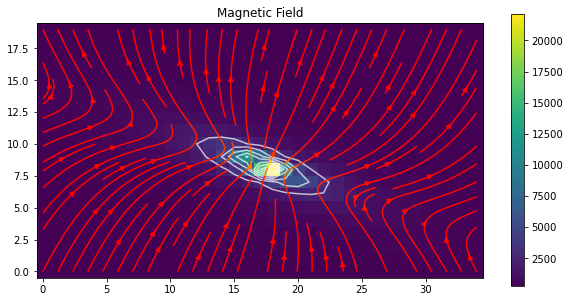

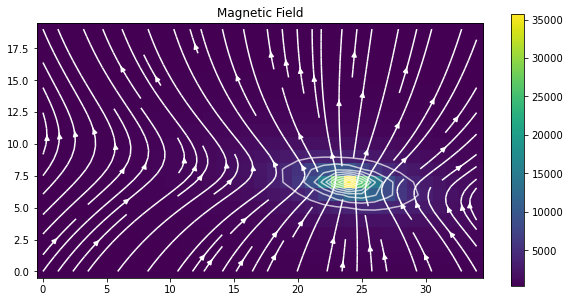

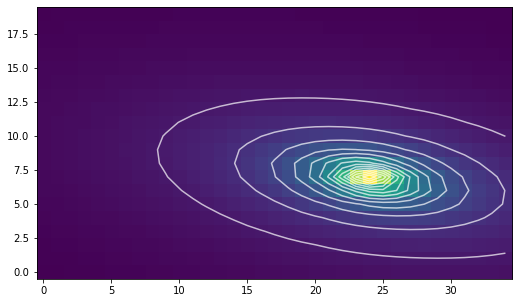

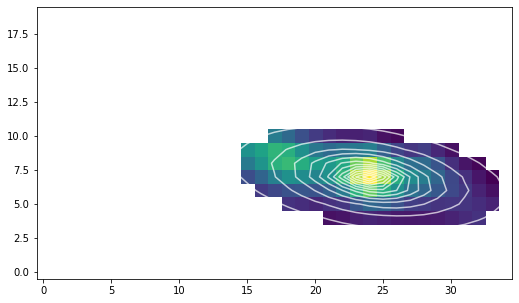

Mean Number density:  4580.406139772924
Median Number density:  4250.686209213932
B_bar : 0.00011891614911175625
Bu =  9.232869654321e-06
B0 =  0.0002751972832245866
161.72757653819764
Angle dispersion =  18.96762852938473


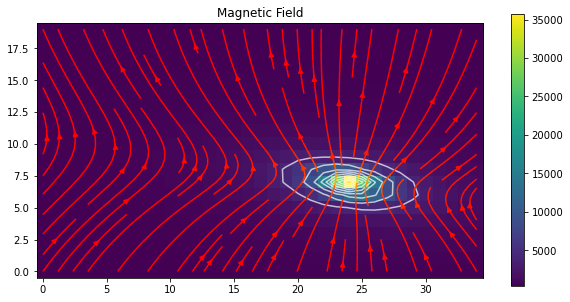

/tmp/ipykernel_450/1273272171.py:292: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)


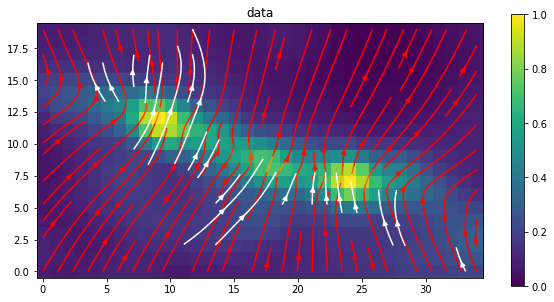

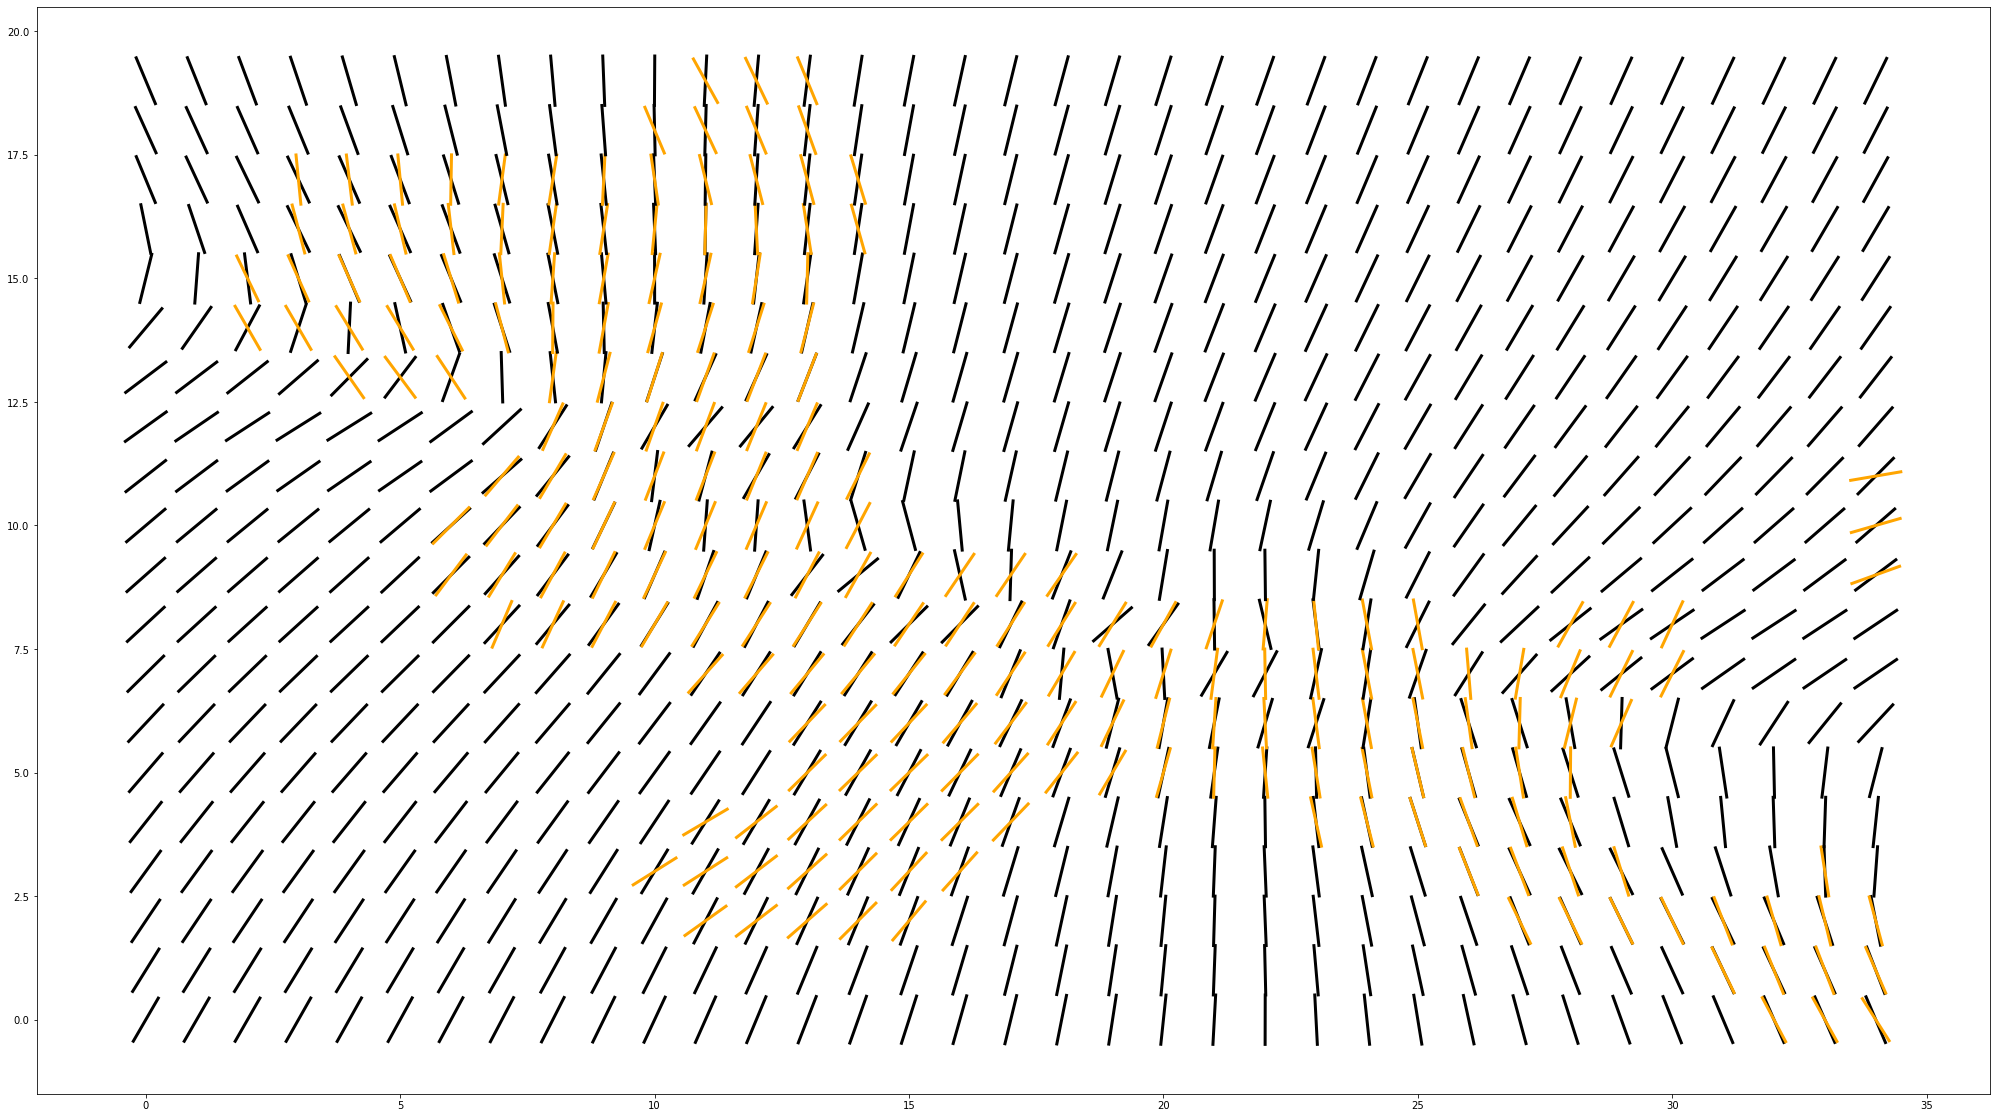

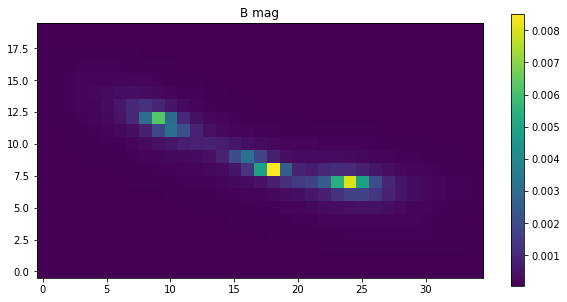

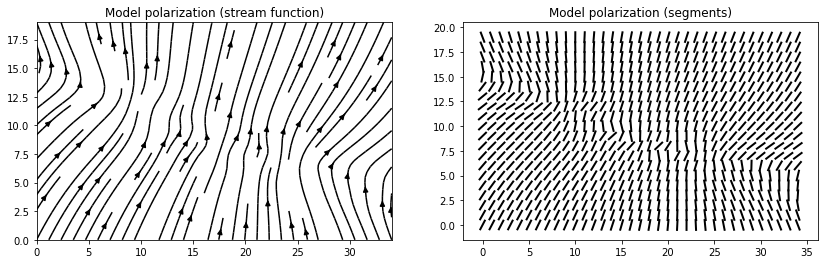

In [42]:
# 1D arrays
width= 35
height=20
X = width
Y = height
z = depth/2

mean_molecular_weight = 2.37 
mu_times_mp = mean_molecular_weight*1.68571016E-24
pixel_size_arcsec = 0.003194444*3600
box_height = 15*6.6/3.4
filament_radius_pc = 1.1
distance = 3400 #pc
cm_in_pc = 3085677581279958500 
cm_in_au = 1.49598073e+13
filament_radius_cm = filament_radius_pc*cm_in_pc
R = filament_radius_cm



grid = np.zeros([Y, X])

x = np.arange(0,X,1)
y = np.arange(0,Y,1)
X,Y = np.meshgrid(x,y)


def lowest_stddev(input_array):
	#delete nan's and unravel
	input_array = np.ravel(input_array)
	nonans = input_array[~np.isnan(input_array)]
	#add 180
	nonans_p180 = [i+180 if i < 0 else i for i in nonans]  
	#nonans_m180 = [i-180 if i > 0 else i for i in nonans]  this is same as above
	#check_distribution(nonans,nonans_p180)
	min_std = np.min([np.std(nonans),np.std(nonans_p180)])
	if np.std(nonans) < np.std(nonans_p180):
		best_median = np.median(nonans)
	else:
		best_median = np.median(nonans_p180)
	return min_std,best_median

def single_1(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            mesh[y,x] = nu+(n01/frac_1)
    return np.array(mesh)
def single_2(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            mesh[y,x] = nu+(n02/frac_2)
    return np.array(mesh)
def single_3(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            mesh[y,x] = nu+(n03/frac_3)
    return np.array(mesh)

def sigle_1_Ngas(mesh,n_0_1, r_0_1, n_u, A_1, theta_1, xcentre_1, ycentre_1):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            mesh[y,x] = part_1
    return np.array(mesh)

def sigle_2_Ngas(mesh, n_0_2, r_0_2, n_u, A_2, theta_2, xcentre_2, ycentre_2):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            mesh[y,x] = part_2
    return np.array(mesh)

def sigle_3_Ngas(mesh,n_0_3, r_0_3, n_u, A_3, theta_3, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_3
    return np.array(mesh)


first = single_1(grid)
second = single_2(grid)
third = single_3(grid)



first_Ngas = sigle_1_Ngas(grid, n01, r01, nu, A1, theta1, x1, y1)
second_Ngas = sigle_2_Ngas(grid, n02, r02, nu, A2, theta2, x2, y2)
third_Ngas = sigle_3_Ngas(grid, n03, r03, nu, A3, theta3, x3, y3)

# Assign vector directions

n1mean = np.mean(first)
n2mean = np.mean(second)
n3mean = np.mean(third)

t = grid.copy()
s = grid.copy()
ang = grid.copy()
check = grid.copy()
thetaB_1 = grid.copy()
v_bar_1 = grid.copy()
v_1 = grid.copy()
B_x_1 = grid.copy()
B_y_1 = grid.copy()
B_1 = grid.copy()
thetaB_2 = grid.copy()
v_bar_2 = grid.copy()
v_2 = grid.copy()
B_x_2 = grid.copy()
B_y_2 = grid.copy()
thetaB_3 = grid.copy()
v_bar_3 = grid.copy()
v_3 = grid.copy()
B_x_3 = grid.copy()
B_y_3 = grid.copy()
for y in range(len(first)):
    for x in range(len(first[y])):
        x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
        y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
        w1 = np.sqrt((x_1/(A1*r01))**2+(y_1/r01)**2)
        t_1 = (1+v01/(1+w1**2))/(1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        s_1 = x_1/y_1
        thetaB_1[y,x] = np.arctan((1-t_1)/((1/s_1)+(s_1*t_1/(A1**2))))
        v_1[y,x] = (1+v01/(1+w1**2))
        v_bar_1[y,x] = (1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        
        B_x_1[y,x] = np.sin(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)
        B_y_1[y,x] = np.cos(thetaB_1[y,x]-theta1)*v_1[y,x]*v_bar_1[y,x]**(-1/3)

        
        x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
        y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
        w2 = np.sqrt((x_2/(A2*r02))**2+(y_2/r02)**2)
        t_2 = (1+v02/(1+w2**2))/(1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        s_2 = x_2/y_2
        thetaB_2[y,x] = np.arctan((1-t_2)/((1/s_2)+(s_2*t_2/(A2**2))))
        v_2[y,x] = (1+v02/(1+w2**2))
        v_bar_2[y,x] = (1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        B_x_2[y,x] = np.sin(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)  #We set the correction for the elongated core as the fraction between the densities to the 2/3
        B_y_2[y,x] = np.cos(thetaB_2[y,x]-theta2)*v_2[y,x]*v_bar_2[y,x]**(-1/3)
        
        x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
        y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3) 
        w3 = np.sqrt((x_3/(A3*r03))**2+(y_3/r03)**2)
        t_3 = (1+v03/(1+w3**2))/(1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        s_3 = x_3/y_3
        thetaB_3[y,x] = np.arctan((1-t_3)/((1/s_3)+(s_3*t_3/(A3**2))))
        v_3[y,x] = (1+v03/(1+w3**2))
        v_bar_3[y,x] = (1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        B_x_3[y,x] = np.sin(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        B_y_3[y,x] = np.cos(thetaB_3[y,x]-theta3)*v_3[y,x]*v_bar_3[y,x]**(-1/3)
        '''
        ang[y,x] = theta
        check[y,x] = (1-t_1)/((1/s_1)+(s_1*t_1/(A1**2)))
        t[y,x] = t_1
        s[y,x] = s_1
        
        if np.sqrt((x1-x)**2+(y1-y)**2) < 15*r01:
            E_x[y,x] = np.sin(-theta1)+(t_1**(2/3))*np.sin(theta-theta1)
            E_y[y,x] = np.cos(-theta1)+(t_1**(2/3))*np.cos(theta-theta1)
        else:
            E_x[y,x] = np.sin(-theta1)
            E_y[y,x] = np.cos(-theta1)
'''
        
        ## data = norm_data
def B_estimate_core(Density_model, Ngas_model, cont_level, Continue, B_x, B_y, v_arr, v_bar_arr, v0, Velocity_dispersion_data,\
                    B_angle_data, Ngas_data,Box_height):
    '''
    Start with cont_level = 0 then choose the appropriate contour and wheter to do density or 
    Run the function with Continue = False first and box_height = 5 then figure out what the box height 
    actually is based on what you see in the cutout plot.
    Once happy with everything just set Continue = True
    '''
    x = np.arange(0,np.shape(Density_model)[1],1)
    y = np.arange(0,np.shape(Density_model)[0],1)
    X,Y = np.meshgrid(x,y)
    
    Density_model_contour_levels = np.arange(np.nanmin(Density_model), np.nanmax(Density_model), (np.nanmax(Density_model)-np.nanmin(Density_model))/10)
    plt.figure(figsize=(10, 5))
    plt.imshow(Density_model, origin='lower')
    plt.colorbar()
    CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color='white', cmap="autumn")
    plt.title('Magnetic Field')
    plt.show()
    #
    
    
    Ngas_model_contour_levels = np.arange(np.nanmin(Ngas_model), np.nanmax(Ngas_model), (np.nanmax(Ngas_model)-np.nanmin(Ngas_model))/15)
    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_model, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()

    emptymap = np.copy(Density_model)
    emptymap[:] = np.nan
    mask = emptymap.copy()

    for i in range(np.shape(Density_model)[0]):
        for j in range(np.shape(Density_model)[1]):
            if Ngas_model_contour_levels[cont_level] <= Ngas_model[i,j]: # and not np.isnan(widths_cut[i,j])
                mask[i,j] = 1
            else:
                mask[i,j] = np.nan

    B_angle_data_crop = B_angle_data*mask
    Velocity_dispersion_data_crop = mask*Velocity_dispersion_data
    v_bar_crop = v_bar_arr*mask
    Ngas_data_crop = Ngas_data*mask

    plt.figure(figsize=(10, 5))
    plt.imshow(Ngas_data_crop, origin='lower')
    CS = plt.contour(Ngas_model, levels=Ngas_model_contour_levels, colors = 'white', alpha = 0.7)
    plt.show()
    if Continue:
        box_height_cm = Box_height*pixel_size_arcsec*distance*cm_in_au
        z = box_height_cm/2


        ave_column = np.nanmean(Ngas_data_crop)
        median_column = np.nanmedian(Ngas_data_crop)
        number_density = ave_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2)))
        sig_PA,median_PA = lowest_stddev(B_angle_data_crop)

        print('Mean Number density: ', number_density)
        print('Median Number density: ', median_column/(np.sqrt(R**2-z**2)+R**2/z*np.arctan(z/np.sqrt(R**2-z**2))))

        B_bar = 0.5*np.sqrt(4*np.pi*number_density*mu_times_mp)*np.nanmean(Velocity_dispersion_data_crop)*100000/np.radians(sig_PA)
        Bu = B_bar/np.nanmin(v_bar_crop)
        print('B_bar :', B_bar)
        print('Bu = ', Bu)
        print('B0 = ', Bu*(1+v0)**(2/3))
        print(v0)
        print('Angle dispersion = ', sig_PA)
        B = Bu*v_arr*(v_bar_arr)**(-1/3)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(Density_model, origin='lower')
        plt.colorbar()
        CS = plt.contour(Density_model, levels=Density_model_contour_levels, colors = 'white', alpha = 0.7)
        plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color=B, cmap="autumn")
        plt.title('Magnetic Field')
        plt.show()
        return (B_x*B, B_y*B)
    
    else:
        return

(B_x_1, B_y_1) = B_estimate_core(Density_model=first, Ngas_model=first_Ngas, cont_level=2, Continue=True, B_x=B_x_1, B_y=B_y_1,\
                                 v_arr=v_1, v_bar_arr=v_bar_1, v0=v01, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

(B_x_2, B_y_2) = B_estimate_core(Density_model=second, Ngas_model=second_Ngas, cont_level=2, Continue=True, B_x=B_x_2, B_y=B_y_2,\
                                 v_arr=v_2, v_bar_arr=v_bar_2, v0=v02, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=2)

(B_x_3, B_y_3) = B_estimate_core(Density_model=third, Ngas_model=third_Ngas, cont_level=2, Continue=True, B_x=B_x_3, B_y=B_y_3,\
                                 v_arr=v_3, v_bar_arr=v_bar_3, v0=v03, Velocity_dispersion_data=widths_cut, B_angle_data=BAngle_data_cut,\
                                 Ngas_data=data,Box_height=7)

### Compare N2H+ and 13CO by themsevles


B_x = B_x_1+B_x_2+B_x_3
B_y = B_y_1+B_y_2+B_y_3
amp = np.sqrt(B_y**2+B_x**2)
plt.figure(figsize=(10, 5))
plt.imshow(data, origin='lower')
plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color=amp, cmap = 'autumn')
plt.title('Magnetic Field')
plt.title('data')
CS = plt.contour(data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.streamplot(X,Y,Bdir_x,Bdir_y, density=1, linewidth=None, color='white')
plt.colorbar()
plt.show()


model_angle = np.arctan(-B_x/B_y)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=model_angle.shape
dlist=[]
list_m=[] # model vector display info
list_r=[] # data vector display info

step=1
scale=step
plt.figure(figsize=(35, 20))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])
        
        x1_d=x-r*np.sin(data_angle[y,x])   
        y1_d=y+r*np.cos(data_angle[y,x])
        x2_d=x+r*np.sin(data_angle[y,x])
        y2_d=y-r*np.cos(data_angle[y,x])
        
        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=3)
        plt.plot([x1_d,x2_d],[y1_d,y2_d], color = 'orange',  linewidth=3) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(amp, origin='lower')
plt.colorbar()
plt.title('B mag')
plt.show()


plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
#plt.figure(figsize=(6,3.4))
#plt.imshow(BAngle_data_cut, origin='lower')
#plt.colorbar(location = 'bottom')
plt.streamplot(X,Y,B_x,B_y, density=1, linewidth=None, color='k')
plt.title('Model polarization (stream function)')
#plt.show()

plt.subplot(1,2,2)
data_angle = np.radians(BAngle_data_cut)
(ys,xs)=data_angle.shape
step=1
scale=step
#plt.figure(figsize=(6,3.4))
for y in range(0,ys,step):
    for x in range(0,xs,step):
        r=scale*0.5
        x1_m=x-r*np.sin(model_angle[y,x])   
        y1_m=y+r*np.cos(model_angle[y,x])
        x2_m=x+r*np.sin(model_angle[y,x])
        y2_m=y-r*np.cos(model_angle[y,x])

        plt.plot([x1_m,x2_m],[y1_m,y2_m], color = 'k',  linewidth=2) 

        #line=np.array([[x1_d,x2_d],[y1_d,y2_d]])
        #list_y_s.append(line)
#gc.show_lines(list_r_s,linewidth=2,color='red')
plt.title('Model polarization (segments)')
plt.savefig('send_phil/model_polarization.pdf')
plt.show()

(23.342435082228985, -19.993845443699293)


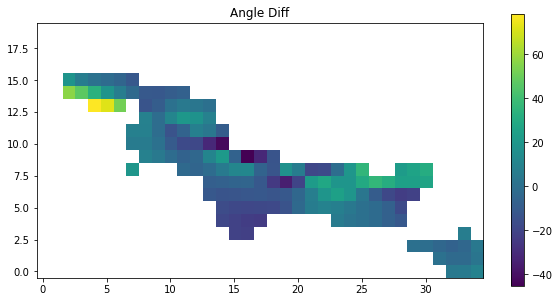

mu =  1.0422693582152234 , sigma =  19.186352458504427
median =  -1.545155944902124


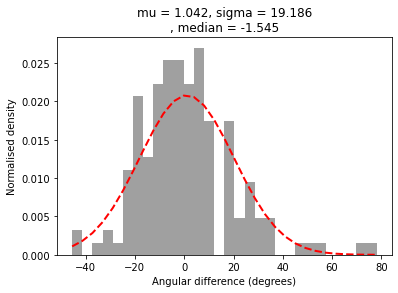

'\nDo column density cut off and be harsher on angle \n'

In [70]:
from scipy.stats import norm
import matplotlib.mlab as mlab
print(lowest_stddev(BAngle_data_cut))
ang_dif =  BAngle_data_cut - np.degrees(np.arctan(-B_x/B_y))
plt.figure(figsize=(10, 5))
plt.imshow(ang_dif, origin='lower')
plt.colorbar()
plt.title('Angle Diff')
plt.show()

fig = plt.figure(figsize=(6, 4))

ang_dif_1d = np.ravel(ang_dif)
ang_dif_clean = list()
for element in ang_dif_1d:
    if not np.isnan(element):
        ang_dif_clean.append(element)

# best fit of data
(mu, sigma) = norm.fit(ang_dif_clean)

# the histogram of the data
n, bins, patches = plt.hist(ang_dif_clean, 30,density=True,  facecolor='grey', alpha=0.75)
print('mu = ', mu, ', sigma = ', sigma)
print('median = ', np.median(ang_dif_clean))
title = 'mu = '+ str(np.around(mu,3))+ ', sigma = '+ str(np.around(sigma,3)) + '\n, median = ' + str(np.around(np.median(ang_dif_clean),3))
# add a 'best fit' line
y = norm.pdf( bins, mu, sigma) 
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Angular difference (degrees)')
plt.ylabel('Normalised density')
plt.title(title)
plt.savefig('send_phil/angle_differences_Ngas>2e22.pdf')
plt.show()

'''
Do column density cut off and be harsher on angle 
'''

reduced chi2 =  0.046685237766448937
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1               1        1      inf        0    False     None     None
A_2               1        1      inf        0    False     None     None
A_3               1        1      inf        0    False     None     None
n_0_1        0.9143        0      inf    0.147     True     None     None
n_0_2        0.8515        0      inf    0.302     True     None     None
n_0_3        0.9509        0      inf   0.1742     True     None     None
n_u        0.007473        0      inf 0.0002344     True     None     None
r_0_1         1.004        0      inf   0.1004     True     None     None
r_0_2        0.7353        0      inf   0.1574     True     None     None
r_0_3        0.9387        0      inf   0.1072     True     None     None
theta_1      -1.382   -1.571    1.571 4.898e+13     True     None     None
theta_2     -0.4776   -1.571    1.571  2.5e+14     True     None     No

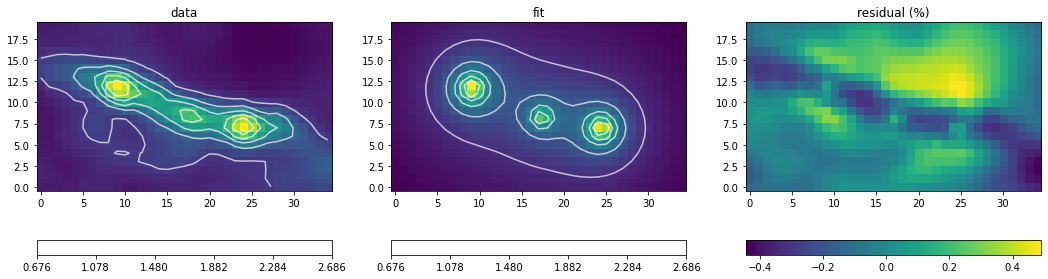

In [118]:
def fitting(mesh,n_0_1, n_0_2, n_0_3, r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            z = depth/2
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)


grid = np.zeros([Y, X])

params = Parameters()
params.add('n_0_1', value=np.max(norm_data), min=0)
params.add('n_0_2', value=np.max(norm_data)/10, min=0)
params.add('n_0_3', value=np.max(norm_data), min=0)
params.add('r_0_1', value=1, min=0)
params.add('r_0_2', value=1, min=0)
params.add('r_0_3', value=1, min=0)
params.add('n_u', value=np.min(norm_data), min=0)
params.add('A_1', value=1, min = 1, vary = False)
params.add('A_2', value=1, min = 1, vary = False)
params.add('A_3', value=1, min = 1, vary = False)
params.add('theta_1', value=0, min = -np.pi/2, max = np.pi/2)
params.add('theta_2', value=0, min = -np.pi/2, max = np.pi/2)
params.add('theta_3', value=0, min = -np.pi/2, max = np.pi/2)
params.add('xcentre_1', value=9.09, min = 0, max = 35, vary = True)
params.add('ycentre_1', value=8.719, min = 0, max = 14, vary = True)
params.add('xcentre_2', value=17.15, min = 0, max = 35, vary = True)
params.add('ycentre_2', value=5.236, min = 0, max = 14, vary = True)
params.add('xcentre_3', value=24, min = 0, max = 35, vary = True)
params.add('ycentre_3', value=4.248, min = 0, max = 14, vary = True)

lmfit_model_pro_per = Model(fitting)
result = lmfit_model_pro_per.fit(norm_data, 
                               mesh = grid, 
                               params = params)

print('reduced chi2 = ', result.redchi)
#print(result.fit_report(show_correl=True))
result.params.pretty_print()

fit =  fitting(grid, result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value,\
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value)


#fit =  fitting(grid, rho_o_1, rho_o_2, rho_o_3, R1, R2, R3, bkg, A1, A2, A3, theta_1, theta_2, theta_3, x0_1, y0_1, x0_2, y0_2, x0_3, y0_3)
residual = (fit - norm_data)/norm_data

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.title('data')
plt.imshow(norm_data, origin='lower')
CS = plt.contour(norm_data, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.subplot(1,3,2)
plt.title('fit')
plt.imshow(fit, origin='lower')
CS = plt.contour(fit, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.subplot(1,3,3)
plt.title('residual (%)')
plt.imshow(residual, origin='lower')
#CS = plt.contour(cont, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.colorbar(location = 'bottom')
plt.show()



(14, 35)
Contour Levels:  [60.65666514 63.01857932 65.3804935  67.74240769 70.10432187 72.46623605
 74.82815024 77.19006442 79.5519786  81.91389279]


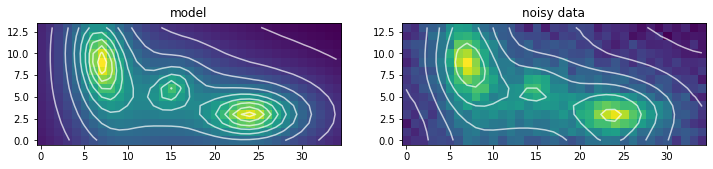

1.4604563054866635e+00
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
A_1           2.316        1      inf     None     True     None     None
A_2           2.773        1      inf     None     True     None     None
A_3               1        1      inf     None     True     None     None
n_0_1         5.051        0      inf     None     True     None     None
n_0_2         1.611        0      inf     None     True     None     None
n_0_3         5.193        0      inf     None     True     None     None
n_u          0.9943        0      inf     None     True     None     None
r_0_1         1.304        0      inf     None     True     None     None
r_0_2         3.037        0      inf     None     True     None     None
r_0_3        0.9178        0      inf     None     True     None     None
theta_1      -1.395   -1.571    1.571     None     True     None     None
theta_2     -0.2005   -1.571    1.571     None     True     None     None
theta_3      

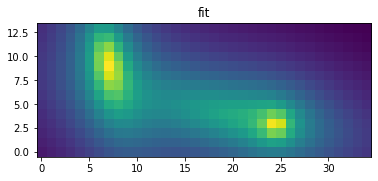

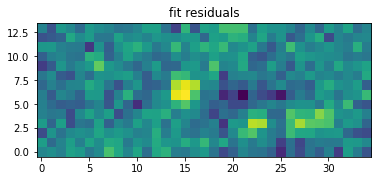

In [104]:

X = 35
Y = 14
depth = 20
num = 200
smooth = 10
x0_1, y0_1 = 7, 9
x0_2, y0_2 = 15, 6
x0_3, y0_3 = 24, 3

R1 = 1.5
R2 = 1.2
R3 = 1.5
bkg = 1
rho_o_1 = 5
rho_o_2 = 3
rho_o_3 = 5
A1 = 2
A2 = 1.3
A3 = 2

angle_1 = -80
theta_1 = angle_1 *np.pi/180
angle_2 = +45
theta_2 = angle_2 *np.pi/180
angle_3 = 0
theta_3 = angle_3 *np.pi/180

x = np.arange(0,X,1)
y = np.arange(0,Y,1)
grid = np.zeros([Y, X])


def Ngas_model_pro_per(data,n_0, r_0, n_u, A, theta, xcentre, ycentre):
    for y1 in range(len(data)):
        for x1 in range(len(data[y1])):
            x = (x1-xcentre)*np.cos(theta)+(y1-ycentre)*np.sin(theta)
            y = -(x1-xcentre)*np.sin(theta)+(y1-ycentre)*np.cos(theta)
            z = depth/2
            sqrt = np.sqrt((x/A)**2+y**2+r_0**2)
            data[y1,x1] = 2*(z*n_u+(np.arctan(z/sqrt)*n_0*r_0**2)/sqrt)
    return np.array(data)

def fitting(mesh,n_0_1, n_0_2, n_0_3, r_0_1, r_0_2, r_0_3, n_u, A_1, A_2, A_3, theta_1, theta_2, theta_3, xcentre_1, ycentre_1, xcentre_2, \
            ycentre_2, xcentre_3, ycentre_3):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-xcentre_1)*np.cos(theta_1)+(y-ycentre_1)*np.sin(theta_1)
            y_1 = -(x-xcentre_1)*np.sin(theta_1)+(y-ycentre_1)*np.cos(theta_1)
            z = depth/2
            sqrt_1 = np.sqrt((x_1/A_1)**2+y_1**2+r_0_1**2)
            part_1 = 2*(z*n_u+(np.arctan(z/sqrt_1)*n_0_1*r_0_1**2)/sqrt_1)
            x_2 = (x-xcentre_2)*np.cos(theta_2)+(y-ycentre_2)*np.sin(theta_2)
            y_2= -(x-xcentre_2)*np.sin(theta_2)+(y-ycentre_2)*np.cos(theta_2)
            sqrt_2 = np.sqrt((x_2/A_2)**2+y_2**2+r_0_2**2)
            part_2 = 2*(z*n_u+(np.arctan(z/sqrt_2)*n_0_2*r_0_2**2)/sqrt_2)
            x_3 = (x-xcentre_3)*np.cos(theta_3)+(y-ycentre_3)*np.sin(theta_3)
            y_3= -(x-xcentre_3)*np.sin(theta_3)+(y-ycentre_3)*np.cos(theta_3)
            sqrt_3 = np.sqrt((x_3/A_3)**2+y_3**2+r_0_3**2)
            part_3 = 2*(z*n_u+(np.arctan(z/sqrt_3)*n_0_3*r_0_3**2)/sqrt_3)
            mesh[y,x] = part_1+part_2+part_3
    return np.array(mesh)


noise_factor = 0.01 
choice = Ngas_model_pro_per  # Ngas_model_pro_par, Ngas_model_pro_per, Ngas_model_obl_par, Ngas_model_obl_per
model = np.add(choice(grid, rho_o_1, R1, bkg, A1, theta_1,x0_1,y0_1), choice(grid,rho_o_2,R2,bkg,A2,theta_2,x0_2,y0_2))
model = np.add(model, choice(grid,rho_o_3,R3,bkg,A3,theta_3,x0_3,y0_3))
print(np.shape(model))
data = model + noise_factor*model.max()*np.random.normal(size=model.shape)
contour_levels = np.arange(np.min(data), np.max(data), (np.max(data)-np.min(data))/10)
cont = gaussian_filter(data, 1.9)
print('Contour Levels: ',contour_levels)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('model')
plt.imshow(model, origin='lower')
CS = plt.contour(model, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.subplot(1,2,2)
plt.title('noisy data')
plt.imshow(data, origin='lower')
CS = plt.contour(cont, levels=contour_levels, colors = 'white', alpha = 0.7)
plt.grid(visible=False)
plt.show()

grid = np.zeros([Y, X])

params = Parameters()
params.add('n_0_1', value=10, min=0)
params.add('n_0_2', value=10, min=0)
params.add('n_0_3', value=10, min=0)
params.add('r_0_1', value=1, min=0)
params.add('r_0_2', value=1, min=0)
params.add('r_0_3', value=1, min=0)
params.add('n_u', value=1.0, min=0)
params.add('A_1', value=1.1, min = 1)
params.add('A_2', value=1.1, min = 1)
params.add('A_3', value=1.1, min = 1)
params.add('theta_1', value=1, min = -np.pi/2, max = np.pi/2)
params.add('theta_2', value=1, min = -np.pi/2, max = np.pi/2)
params.add('theta_3', value=1, min = -np.pi/2, max = np.pi/2)
params.add('xcentre_1', value=5, min = 0)
params.add('ycentre_1', value=10, min = 0)
params.add('xcentre_2', value=17, min = 0)
params.add('ycentre_2', value=8, min = 0)
params.add('xcentre_3', value=25, min = 0)
params.add('ycentre_3', value=3, min = 0)

lmfit_model_pro_per = Model(fitting)
result = lmfit_model_pro_per.fit(data, 
                               mesh = grid, 
                               params = params)

print(result.redchi)
#print(result.fit_report(show_correl=True))
result.params.pretty_print()

fit =  fitting(grid, result.params['n_0_1'].value, result.params['n_0_2'].value, result.params['n_0_3'].value, result.params['r_0_1'].value, \
               result.params['r_0_2'].value, result.params['r_0_3'].value,result.params['n_u'].value,result.params['A_1'].value, \
               result.params['A_2'].value, result.params['A_3'].value, result.params['theta_1'].value, result.params['theta_2'].value, \
               result.params['theta_3'].value, result.params['xcentre_1'].value, result.params['ycentre_1'].value, result.params['xcentre_2'].value, \
               result.params['ycentre_2'].value, result.params['xcentre_3'].value, result.params['ycentre_3'].value)


#fit =  fitting(grid, rho_o_1, rho_o_2, rho_o_3, R1, R2, R3, bkg, A1, A2, A3, theta_1, theta_2, theta_3, x0_1, y0_1, x0_2, y0_2, x0_3, y0_3)
residual = data - fit
print(np.shape(data))
plt.figure(figsize=(6,6))
plt.title('fit')
plt.imshow(fit, origin='lower')
plt.show()
plt.figure(figsize=(6,6))
plt.title('fit residuals')
plt.imshow(residual, origin='lower')
plt.show()
#CS = plt.contour(cont, levels=contour_levels, colors = 'white', alpha = 0.7)

185.70413930332685 23731.582598862748
<class 'numpy.ndarray'> (200, 200)
min t  251.20817294594045
(15, 15) (15, 15)


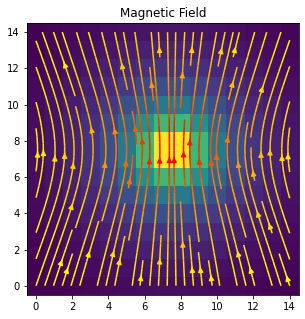

"\nImportant note for what to do in future:\nNow I need to do DCF analysis of model based on real velocity dispersion data. Choose a radius which is not too crazy but encompasses most of what we are looking at. Do a standard DCF where \nyou use average over entire area and ALSO do one where we do DCF analysis for each pixel (using Cheyu Chen approx for angular dispersion) then average all of the Bfield estimates. '\n\n\nThen check and compare to see what difference is. \n\n"

In [247]:
# 1D arrays
width= 15
height=15
X = width
Y = height

print(nu, n01)

theta1 = 0
x1 = X/2
y1 = Y/2
A1 = 1
r01 = 2

grid = np.zeros([Y, X])

x = np.arange(0,X,1)
y = np.arange(0,Y,1)
X,Y = np.meshgrid(x,y)


def single_1(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
            y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
            frac_1 = (x_1/(A1*r01))**2+(y_1/r01)**2+1
            mesh[y,x] = nu+(n01/frac_1)
    return np.array(mesh)
def single_2(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
            y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
            frac_2 = (x_2/(A2*r02))**2+(y_2/r02)**2+1
            mesh[y,x] = nu+(n02/frac_2)
    return np.array(mesh)
def single_3(mesh):
    for y in range(len(mesh)):
        for x in range(len(mesh[y])):
            x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
            y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3)
            frac_3 = (x_3/(A3*r03))**2+(y_3/r03)**2+1
            mesh[y,x] = nu+(n03/frac_3)
    return np.array(mesh)
first = single_1(grid)
second = single_2(grid)
third = single_3(grid)
# Assign vector directions

n1mean = np.mean(first)
n2mean = np.mean(second)
n3mean = np.mean(third)

t = grid.copy()
s = grid.copy()
ang = grid.copy()
check = grid.copy()
B_x_1 = grid.copy()
B_y_1 = grid.copy()
B_x_2 = grid.copy()
B_y_2 = grid.copy()
B_x_3 = grid.copy()
B_y_3 = grid.copy()
print(type(E_x), np.shape(E_x))
for y in range(len(first)):
    for x in range(len(first[y])):
        x_1 = (x-x1)*np.cos(theta1)+(y-y1)*np.sin(theta1)
        y_1 = -(x-x1)*np.sin(theta1)+(y-y1)*np.cos(theta1)
        w1 = np.sqrt((x_1/(A1*r01))**2+(y_1/r01)**2)
        t_1 = (1+v01/(1+w1**2))/(1+(3*v01/(w1**2))*(1-(np.arctan(w1)/w1))) 
        s_1 = x_1/y_1
        thetaB_1 = np.arctan((1-t_1)/((1/s_1)+(s_1*t_1/(A1**2))))
        B_x_1[y,x] = (t_1**(-2/3))*np.sin(thetaB_1-theta1)
        B_y_1[y,x] = (t_1**(-2/3))*np.cos(thetaB_1-theta1)
        
        x_2 = (x-x2)*np.cos(theta2)+(y-y2)*np.sin(theta2)
        y_2 = -(x-x2)*np.sin(theta2)+(y-y2)*np.cos(theta2)
        w2 = np.sqrt((x_2/(A2*r02))**2+(y_2/r02)**2)
        t_2 = (1+v02/(1+w2**2))/(1+(3*v02/(w2**2))*(1-(np.arctan(w2)/w2))) 
        s_2 = x_2/y_2
        thetaB_2 = np.arctan((1-t_2)/((1/s_2)+(s_2*t_2/(A2**2))))
        B_x_2[y,x] = (t_2**(2/3))*np.sin(thetaB_2-theta2)*(result.params['factor'].value)**(2/3) #We set the correction for the elongated core as the fraction between the densities to the 2/3
        B_y_2[y,x] = (t_2**(2/3))*np.cos(thetaB_2-theta2)*(result.params['factor'].value)**(2/3) 
        
        x_3 = (x-x3)*np.cos(theta3)+(y-y3)*np.sin(theta3)
        y_3 = -(x-x3)*np.sin(theta3)+(y-y3)*np.cos(theta3) 
        w3 = np.sqrt((x_3/(A3*r03))**2+(y_3/r03)**2)
        t_3 = (1+v03/(1+w3**2))/(1+(3*v03/(w3**2))*(1-(np.arctan(w3)/w3))) 
        s_3 = x_3/y_3
        thetaB_3 = np.arctan((1-t_3)/((1/s_3)+(s_3*t_3/(A3**2))))
        B_x_3[y,x] = (t_3**(2/3))*np.sin(thetaB_3-theta3)
        B_y_3[y,x] = (t_3**(2/3))*np.cos(thetaB_3-theta3)
        '''
        ang[y,x] = theta
        check[y,x] = (1-t_1)/((1/s_1)+(s_1*t_1/(A1**2)))
        t[y,x] = t_1
        s[y,x] = s_1
        
        if np.sqrt((x1-x)**2+(y1-y)**2) < 15*r01:
            E_x[y,x] = np.sin(-theta1)+(t_1**(2/3))*np.sin(theta-theta1)
            E_y[y,x] = np.cos(-theta1)+(t_1**(2/3))*np.cos(theta-theta1)
        else:
            E_x[y,x] = np.sin(-theta1)
            E_y[y,x] = np.cos(-theta1)
'''

B_x = B_x_1+B_x_2+B_x_3
B_y = B_y_1+B_y_2+B_y_3
col = np.sqrt(B_x**2+B_y**2)


# Depict illustratio
print('min t ',np.min(t))


print(np.shape(X), np.shape(Y))

col_1 = np.sqrt(B_x_1**2+B_y_1**2)

plt.figure(figsize=(10, 5))
plt.imshow(first, origin='lower')
plt.streamplot(X,Y,B_x_1,B_y_1, density=1, linewidth=None, color=col_1, cmap="autumn")
plt.title('Magnetic Field')
plt.show()



'''
Important note for what to do in future:
Now I need to do DCF analysis of model based on real velocity dispersion data. Choose a radius which is not too crazy but encompasses most of what we are looking at. Do a standard DCF where 
you use average over entire area and ALSO do one where we do DCF analysis for each pixel (using Cheyu Chen approx for angular dispersion) then average all of the Bfield estimates. '


Then check and compare to see what difference is. 

'''

Paper Outline:

Intro:
- What are bones, why 